- Change the path of helper.r if needed

In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)
## if there is any conflict of duplicate functions between helper and stats
## we use the function of stats

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

 number of cores, set this number according to your computer

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [3]:
product_list = ["IF", "IH", "IC", "T", "TF"]

- get all of the dates

In [4]:
import dask
from dask import compute, delayed

- get good night date

- now it's see why we use this kind of data

In [5]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
n_days = len(all_dates)


- we randomly choose a day

In [6]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[0])

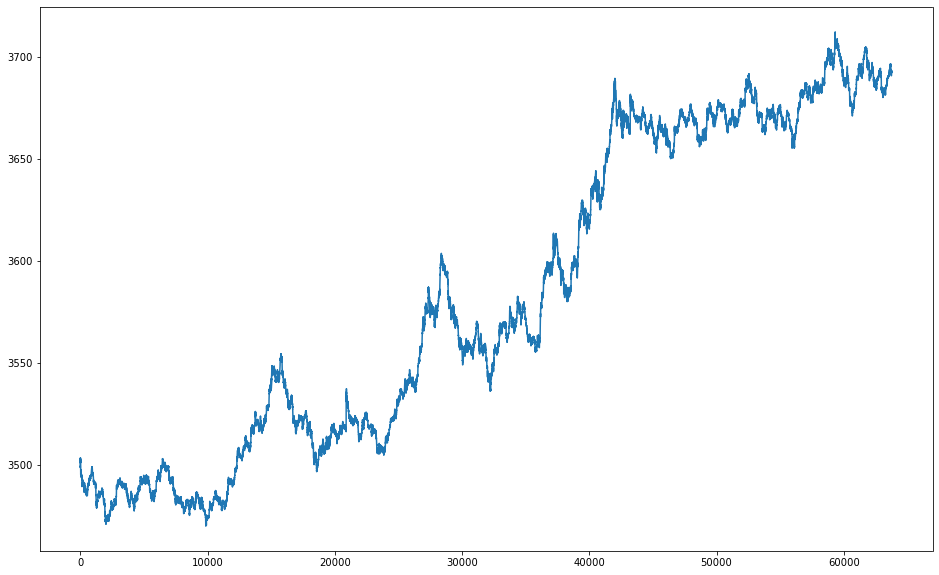

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- plot the maximum price of 2048 ticks
- plot the minimum price of 2048 ticks

In [9]:
period_list = [1024, 2048, 4096]

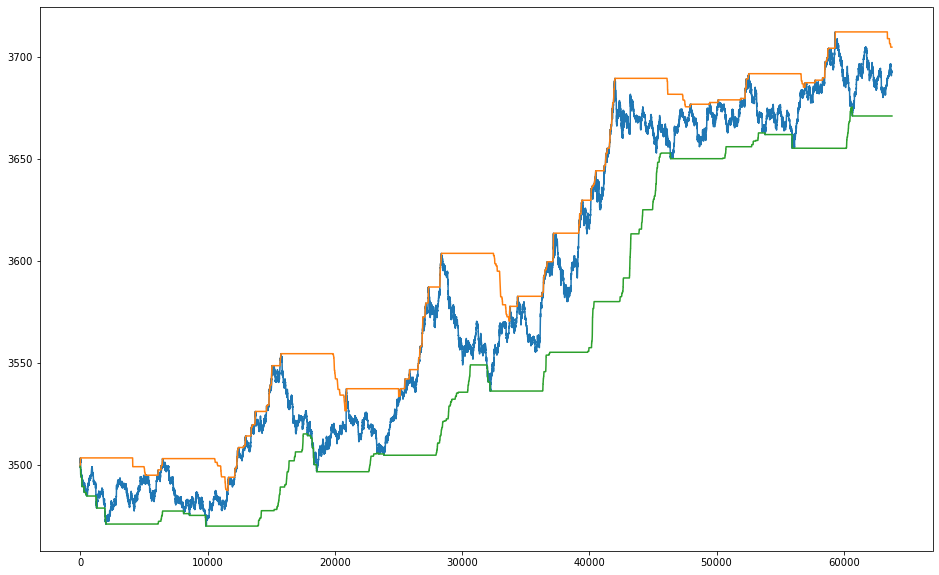

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values)
plt.plot(data["max.4096"].values)
plt.plot(data["min.4096"].values);

## we can see the result meets our expectation
## it may take long time to calculate the min and max of wpr prices
## I give you the estimated time of using 4 cores, so you can deal with other affairs while waiting for result
## but signals using min/max would be sometimes very useful
## the the time to calculating min/max pay off in the end
## In practice, when using c++ to calculating min/max on a rolling basis
## there would be some efficient algorithm, which is faster than comparing all numbers at every tick
## we would talk about it later in our C++ class

- Test 5 predictive signals and generate each result
- now let's see the first signal, which is simply related to price action without trading volume


- set the sample period length

In [11]:
period = 4096

- the first signal

In [10]:
## to calculate the normalized return
## class of factor
## 3 parts: factor_name, params, formula
## 2^[10:13]=(1024,2048,3096)
## the idea is ret/|ret|
## then over a period, we divided by period in numerator and denominator
## (ret/period)/(|ret|/period)
## then we use ewma(ret)/ewma(|ret|) instead of mean return
## because calculate ewma is faster and easier
## but the first period items may not be correct for ewma
## so we use adjust=True
## but since there is avdivision, actually we don't need to use adjust=True
## they would be the same with or withour adjust=True
from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

In [11]:
## procedure to calculate a signal
## first use a variable to define the class object
x2 = foctor_nr_period()
SAVE_PATH = "e:/intern"
## then create directories to save the result
for product in product_list:
    create_signal_path(x2, product, SAVE_PATH);
    
# e:/intern/tmp pkl/IF/nr.1024
# e:/intern/tmp pkl/IF/nr.2048
# e:/intern/tmp pkl/IF/nr.4096
# e:/intern/tmp pkl/IH/nr.1024
# e:/intern/tmp pkl/IH/nr.2048
# e:/intern/tmp pkl/IH/nr.4096
# e:/intern/tmp pkl/IC/nr.1024
# e:/intern/tmp pkl/IC/nr.2048
# e:/intern/tmp pkl/IC/nr.4096
# e:/intern/tmp pkl/T/nr.1024
# e:/intern/tmp pkl/T/nr.2048
# e:/intern/tmp pkl/T/nr.4096
# e:/intern/tmp pkl/TF/nr.1024
# e:/intern/tmp pkl/TF/nr.2048
# e:/intern/tmp pkl/TF/nr.4096

e:/intern/tmp pkl/IF/nr.1024
e:/intern/tmp pkl/IF/nr.2048
e:/intern/tmp pkl/IF/nr.4096
e:/intern/tmp pkl/IH/nr.1024
e:/intern/tmp pkl/IH/nr.2048
e:/intern/tmp pkl/IH/nr.4096
e:/intern/tmp pkl/IC/nr.1024
e:/intern/tmp pkl/IC/nr.2048
e:/intern/tmp pkl/IC/nr.4096
e:/intern/tmp pkl/T/nr.1024
e:/intern/tmp pkl/T/nr.2048
e:/intern/tmp pkl/T/nr.4096
e:/intern/tmp pkl/TF/nr.1024
e:/intern/tmp pkl/TF/nr.2048
e:/intern/tmp pkl/TF/nr.4096


In [15]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x2, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 6min 6s


In [17]:
## utilize the bid and ask quantity changes
## but the original quantity may not be stationary, i.e. it would have very large values
## usually from 0 to 200
## but can be up to several tens of thousand
## so we use the change of qty's direction instead
## it has only -1 0 1 so it's stionary, but it's dicrerte
## then we add ewma as fitler to make it more continuous
## we hope the signals are continuous values

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [18]:
x3 = foctor_dbook_period()
x3
# factor_name:
# dbook.period

# formula:
#     def formula(self, data, period):
#         diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
#         diff_bid_qty[0] = 0
#         diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
#         diff_ask_qty[0] = 0
#         return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


# params:
# $period:[1024 2048 4096]

factor_name:
dbook.period

formula:
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


params:
$period:[1024 2048 4096]

- create directory for dbook signal

In [19]:
SAVE_PATH = "e:/intern"
for product in product_list:
    create_signal_path(x3, product, SAVE_PATH)

e:/intern/tmp pkl/IF/dbook.1024
e:/intern/tmp pkl/IF/dbook.2048
e:/intern/tmp pkl/IF/dbook.4096
e:/intern/tmp pkl/IH/dbook.1024
e:/intern/tmp pkl/IH/dbook.2048
e:/intern/tmp pkl/IH/dbook.4096
e:/intern/tmp pkl/IC/dbook.1024
e:/intern/tmp pkl/IC/dbook.2048
e:/intern/tmp pkl/IC/dbook.4096
e:/intern/tmp pkl/T/dbook.1024
e:/intern/tmp pkl/T/dbook.2048
e:/intern/tmp pkl/T/dbook.4096
e:/intern/tmp pkl/TF/dbook.1024
e:/intern/tmp pkl/TF/dbook.2048
e:/intern/tmp pkl/TF/dbook.4096


In [21]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3, product=product, HEAD_PATH=SAVE_PATH)
;

# Wall time: 4min 18s


Wall time: 4min 40s


''

In [69]:
def moving_average(a, n=3) :
    ret_sum = np.cumsum(a, dtype=float)
    ret = a
    ret[n:] = (ret_sum[n:] - ret_sum[:-n])/n
    return ret


- now we write the all.signal part into a function

In [192]:
def get_all_signal(file_list, product, signal_name, period, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern"):
    n_files = len(file_list)
    to_choose = (np.arange(n_files)+1) % 10 == 0
    all_signal = np.array([])
    for file in file_list[to_choose]:
        S = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        signal = S[data["good"]]
        moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal

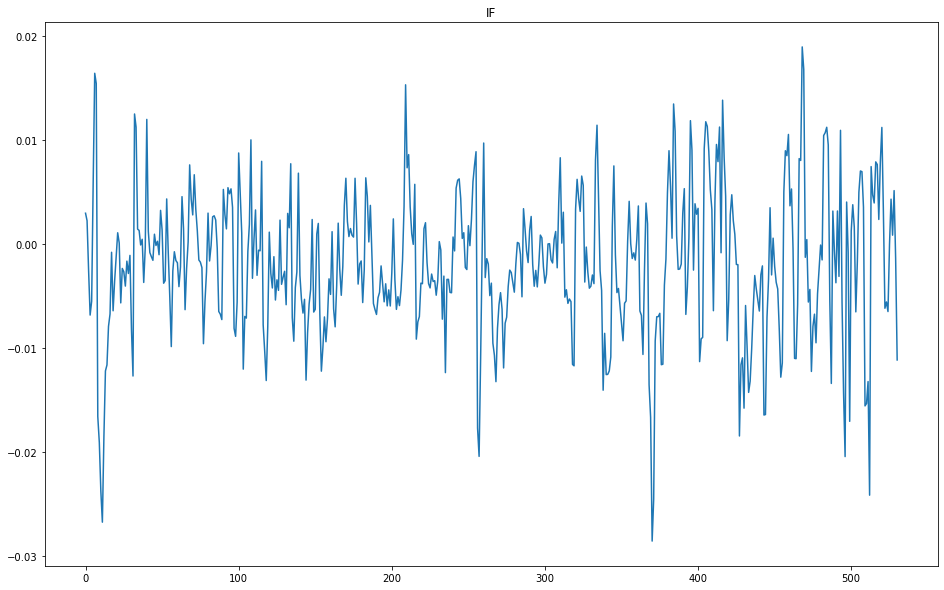

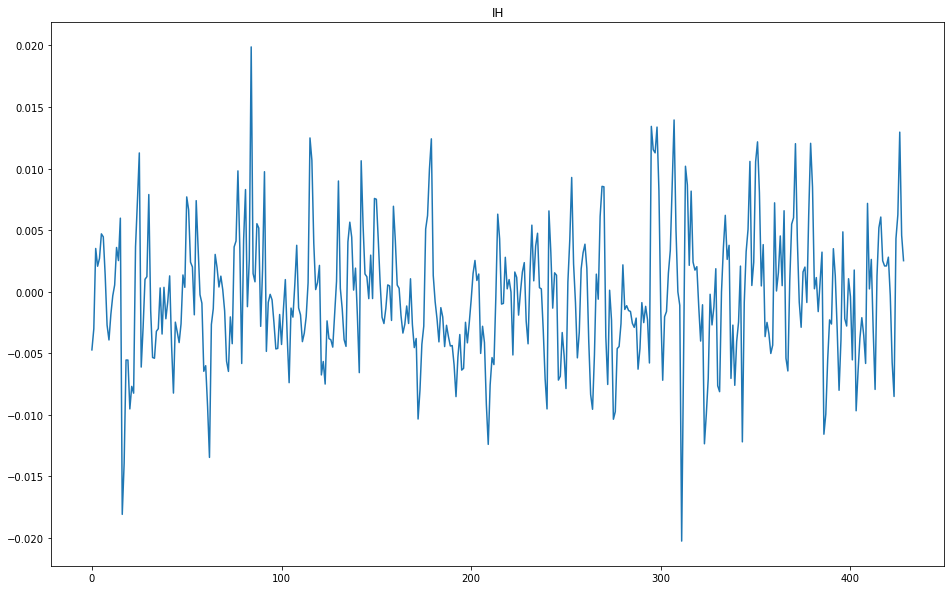

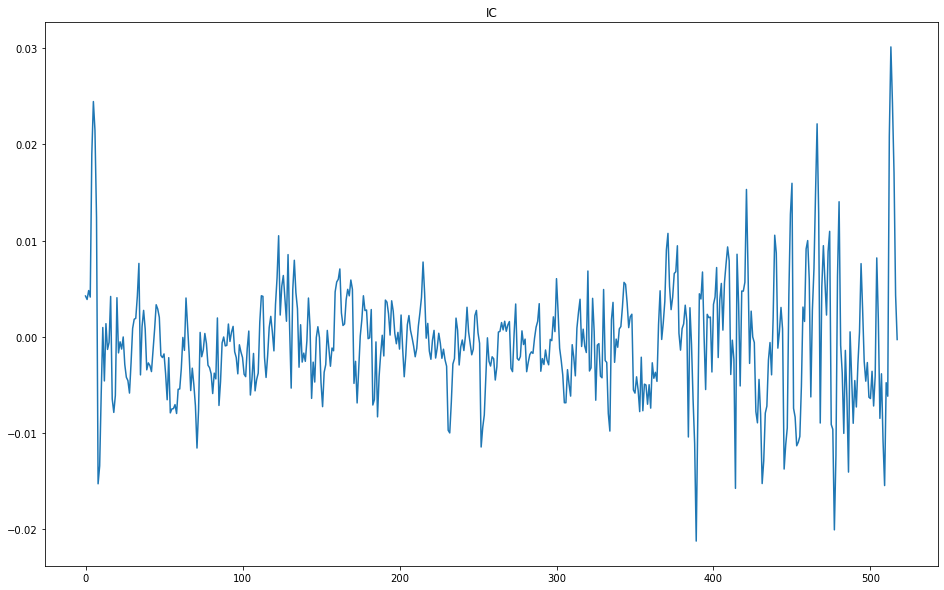

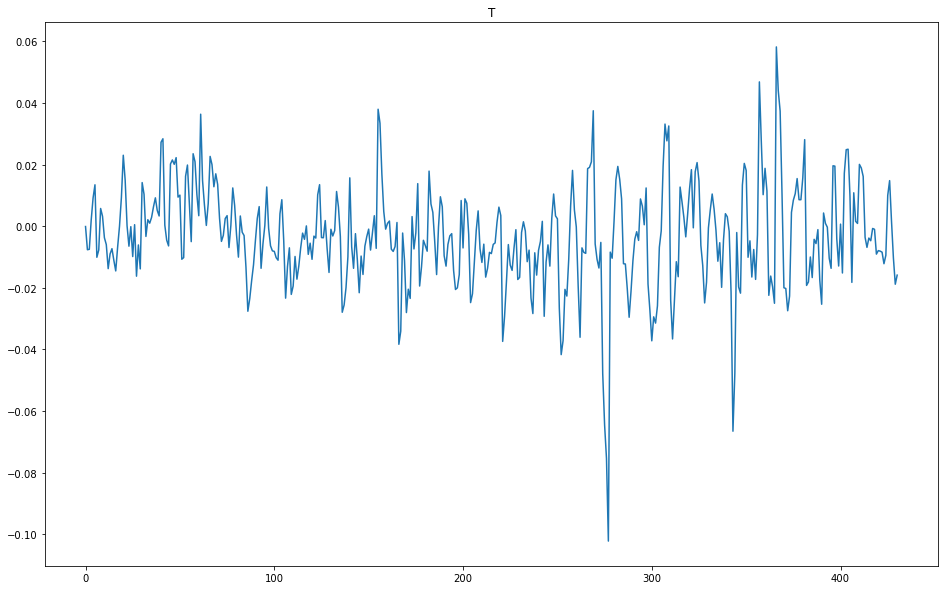

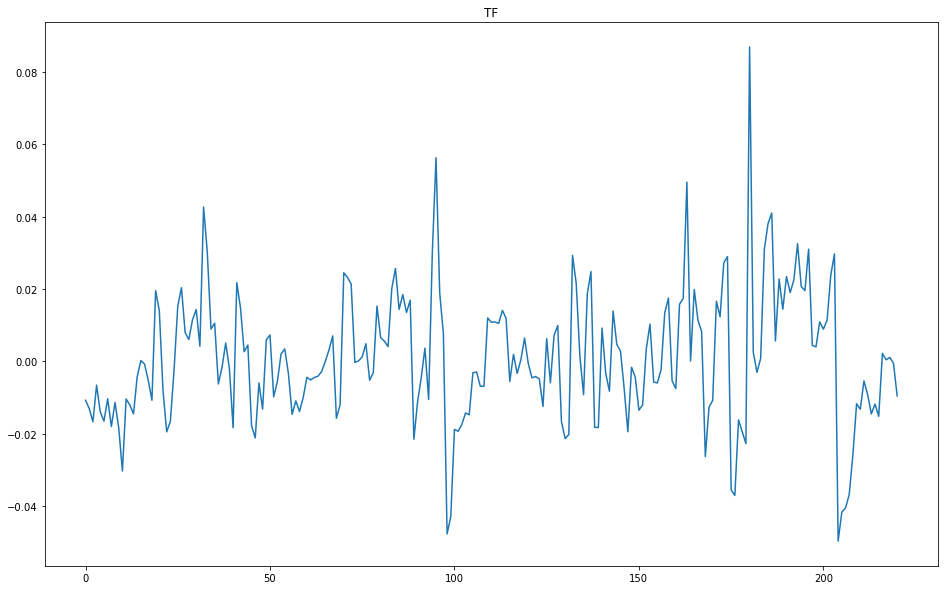

In [78]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "dbook."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [79]:
print(len(all_signal))
## 221


221


- there is no extreme values

In [26]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.005, 0.021, 0.0008)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
index_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


from collections import OrderedDict
import itertools
open_list = np.arange(0.02, 0.041, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
treasury_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


In [106]:
treasury_thre_mat

open  close
0    0.02 -0.004
1    0.02 -0.008
2    0.02 -0.012
3    0.02 -0.016
4    0.02 -0.020
..    ...    ...
100  0.04 -0.008
101  0.04 -0.016
102  0.04 -0.024
103  0.04 -0.032
104  0.04 -0.040

[105 rows x 2 columns]

- get the result of training sample

In [13]:
period = 4096
signal_name = "dbook."+str(period)

In [17]:
train_sample = np.array(all_dates)<"2018"

In [18]:
sum(train_sample)
## 510

510

In [19]:
test_sample = np.array(all_dates)>"2018"
sum(test_sample)
## 582

582

In [100]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
SAVE_PATH = "e:/intern"
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product=="IF" or product=="IH" or product=="IC":
        thre_mat = index_thre_mat
        atr_filter = 100
    else:
        thre_mat = treasury_thre_mat
        atr_filter = 20
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=atr_filter)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

#Wall time:  33min 19s


Wall time: 33min 19s


In [101]:
## save backtest result
save(all_trade_stat, SAVE_PATH+"/"+"all_trade_stat_"+signal_name+".new.pkl")

In [14]:
all_trade_stat = load(SAVE_PATH+"/"+"all_trade_stat_"+signal_name+".new.pkl")

In [112]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
SAVE_PATH = "e:/intern"
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product=="IF" or product=="IH" or product=="IC":
        thre_mat = index_thre_mat
        atr_filter = 100
    else:
        thre_mat = treasury_thre_mat
        atr_filter = 20
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=atr_filter)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

#Wall time:  33min 19s


Wall time: 38min 29s


In [113]:
save(all_trade_stat, SAVE_PATH+"/"+"all_trade_stat_"+signal_name+".pos.pkl")

- get the statistics result of training sample

In [31]:
all_trade_stat = load(SAVE_PATH+"/"+"all_trade_stat_"+signal_name+".pos.pkl")
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

- let's see how many good signals there are

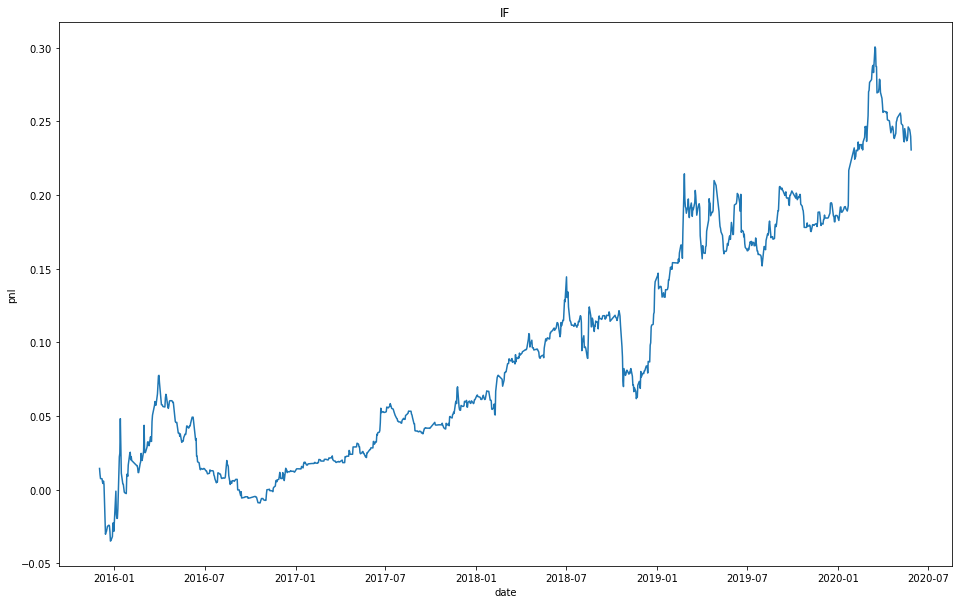

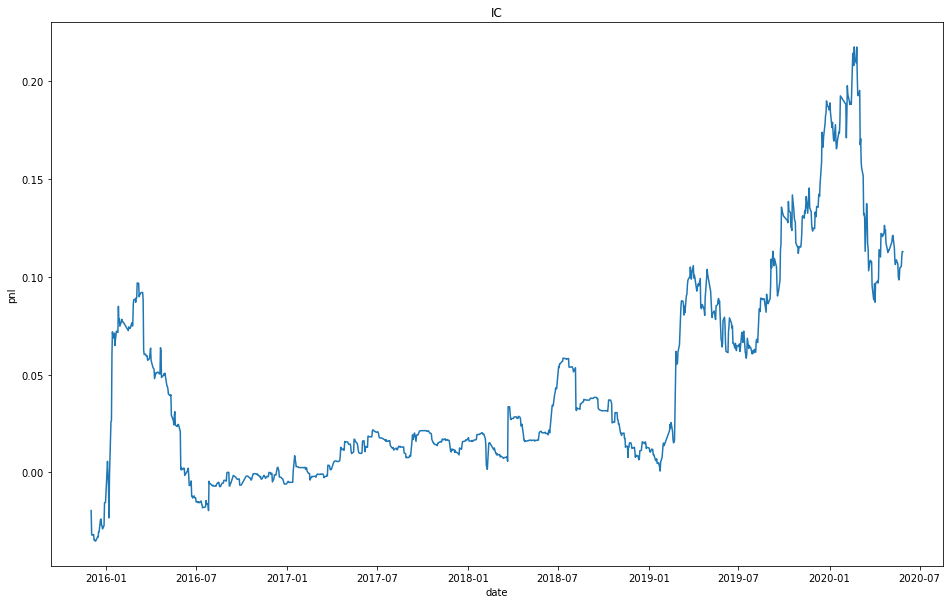

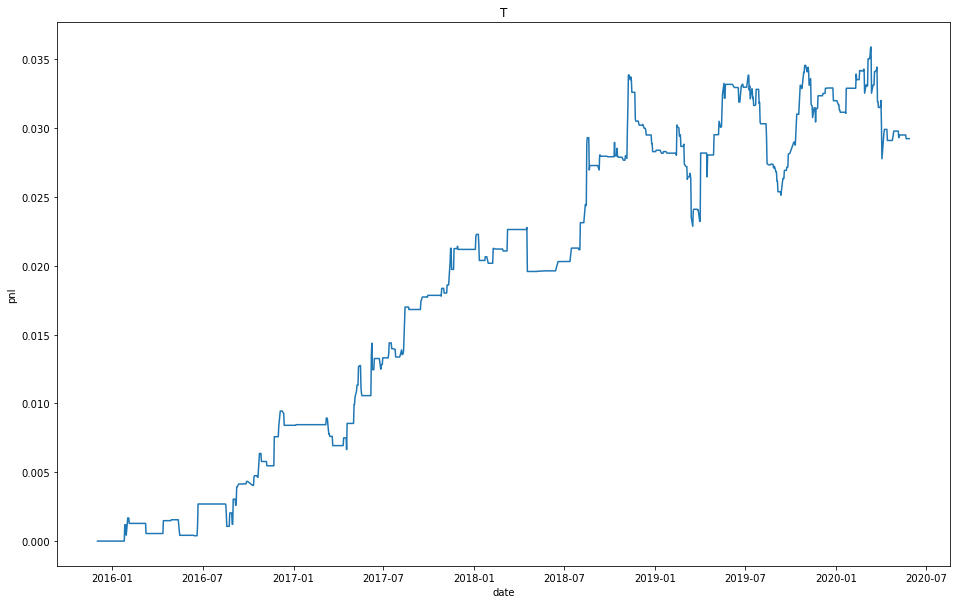

In [121]:
all_trade_stat = load(SAVE_PATH+"/"+"all_trade_stat_"+signal_name+".pos.pkl")
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

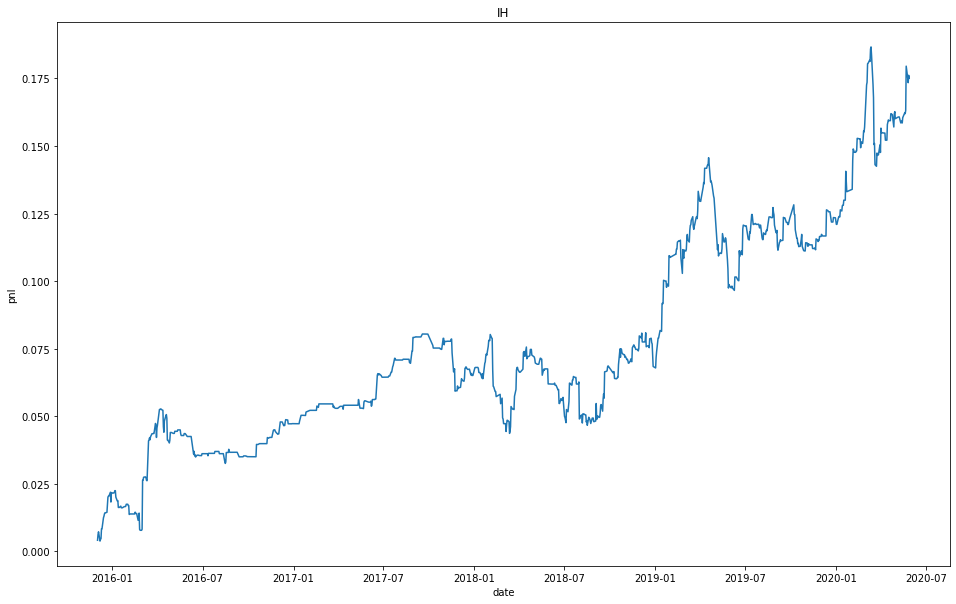

In [122]:
all_trade_stat = load(SAVE_PATH+"/"+"all_trade_stat_"+signal_name+".new.pkl")
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

- we can see the result is quite good
- now we can split the samples into training and testing sets

In [27]:
%%time
train_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product=="IF" or product=="IH" or product=="IC":
        thre_mat = index_thre_mat
        atr_filter = 100
    else:
        thre_mat = treasury_thre_mat
        atr_filter = 20
    if product=="IH":
        reverse = -1;
    else:
        reverse = 1
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio, 
                                 HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=atr_filter)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat
    
## Wall time: 16min 30s

Wall time: 12min 35s


In [28]:
save(train_trade_stat, SAVE_PATH+"/" + signal_name+"_train_trade_stat.pkl")

In [29]:
train_trade_stat = load(SAVE_PATH+"/" + signal_name+"_train_trade_stat.pkl")

d:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


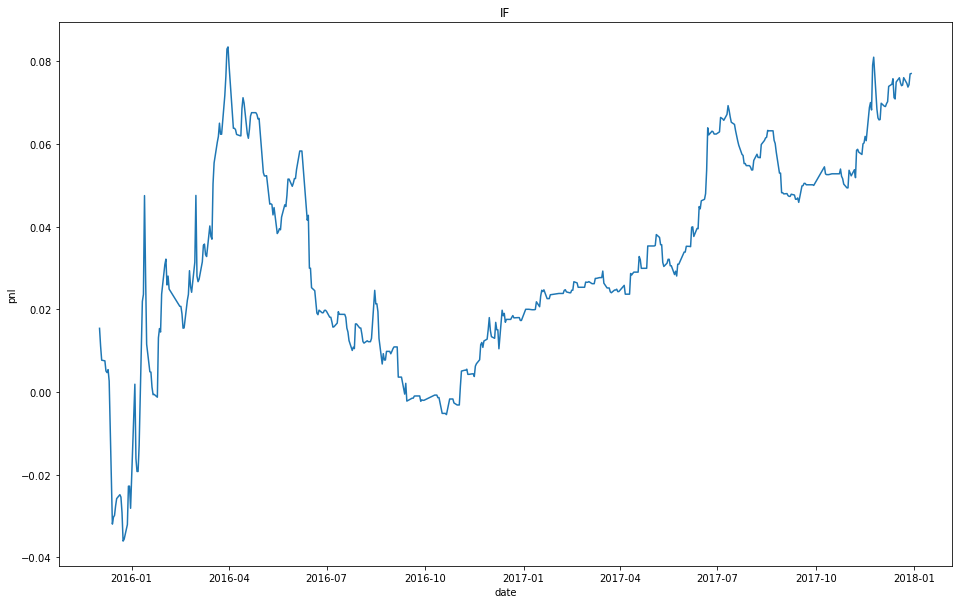

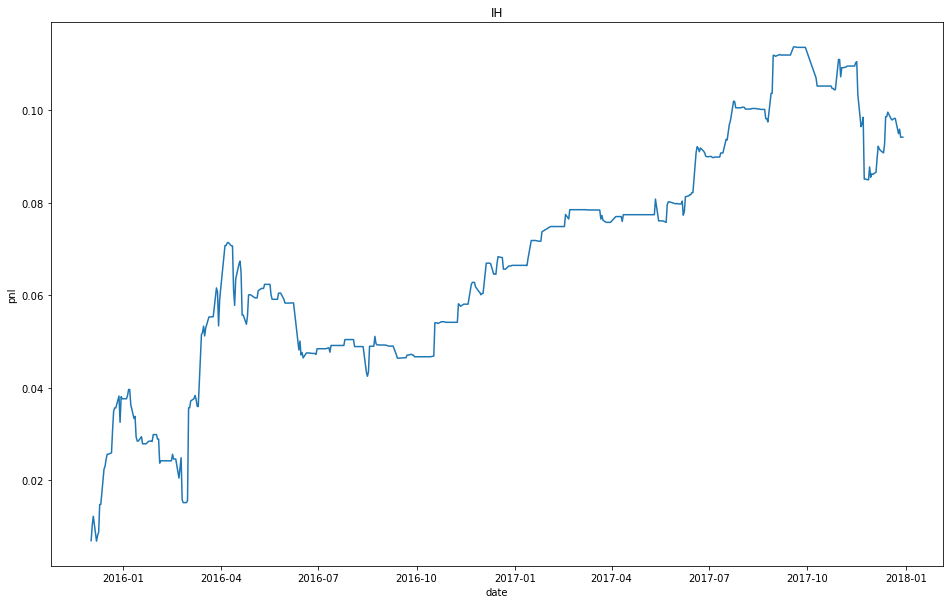

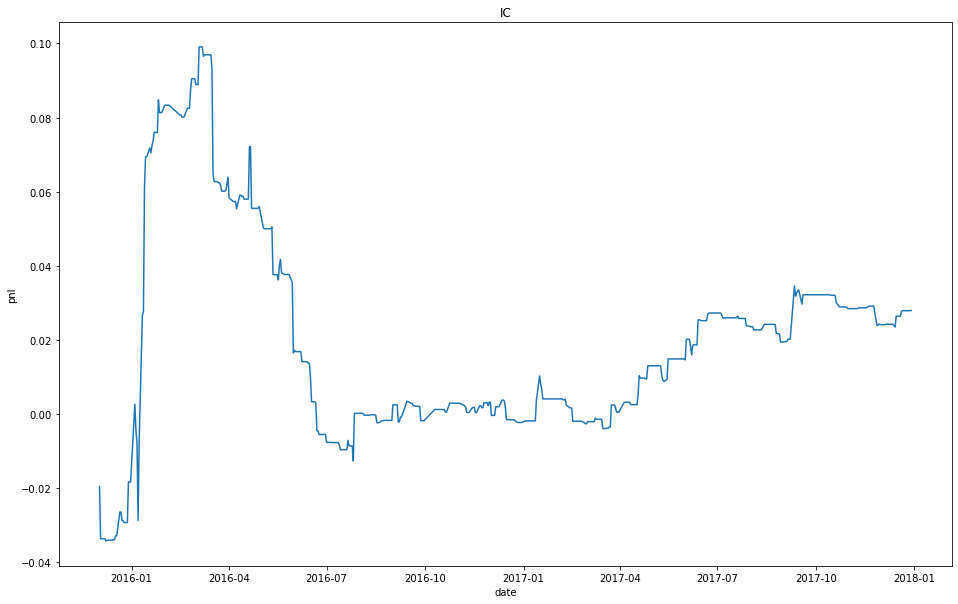

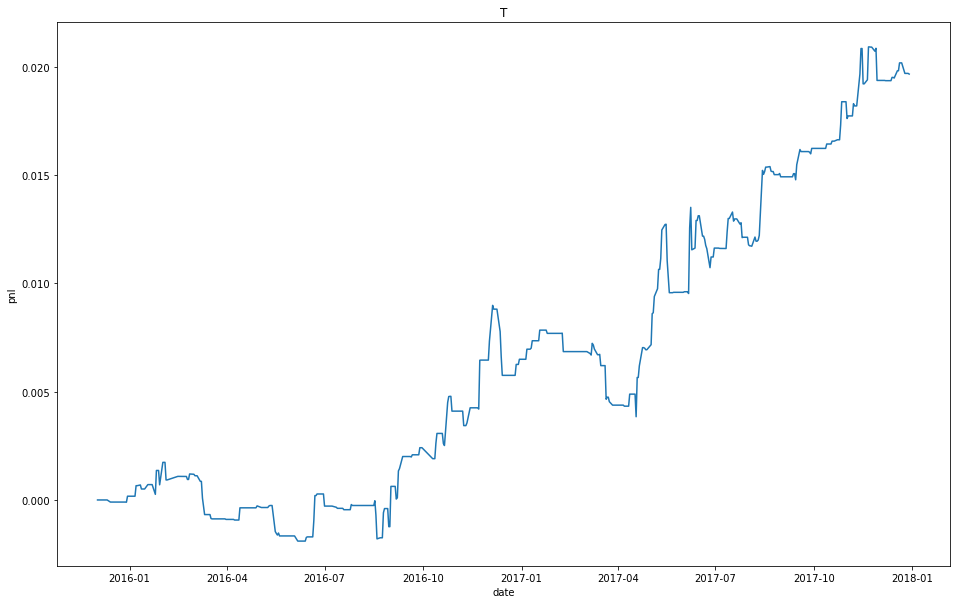

In [32]:
i = 0
train_trade_stat = load(SAVE_PATH+"/" + signal_name +"_train_trade_stat.pkl")
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates[train_sample], good_pnl.cumsum());

In [37]:
%%time
test_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product=="IF" or product=="IH" or product=="IC":
        thre_mat = index_thre_mat
        atr_filter = 100
    else:
        thre_mat = treasury_thre_mat
        atr_filter = 20
    if product=="IH":
        reverse = -1;
    else:
        reverse = 1

    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=atr_filter)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
    test_trade_stat[product] = trade_stat
    
# Wall time: 23min

Wall time: 23min


- at last we plot the selected pnl

- we can check its sharp ratio

In [38]:
save(test_trade_stat, SAVE_PATH+"/" + signal_name + "_finance_test_trade_stat.pkl")

In [39]:
test_trade_stat = load(SAVE_PATH+"/" + signal_name + "_finance_test_trade_stat.pkl")

- now let's check how it performs on the test set

IF train sharpe  0.5353755054538243 test sharpe  0.8568520744637975
IH train sharpe  1.2424590311529555 test sharpe  0.8789082288628026
IC train sharpe  0.22210808214994088 test sharpe  0.40848131218782535
T train sharpe  1.369895717812262 test sharpe  0.24940131729662374


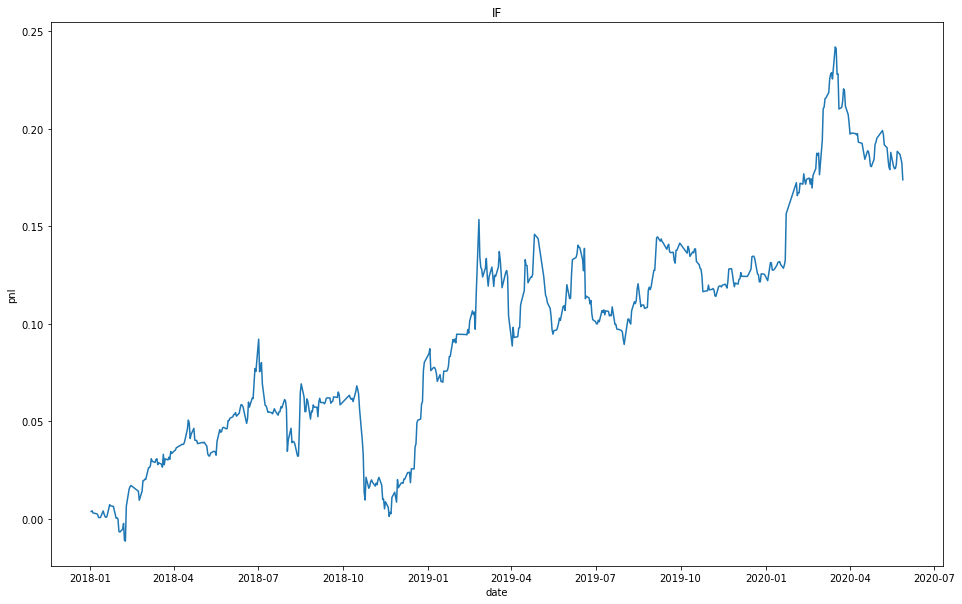

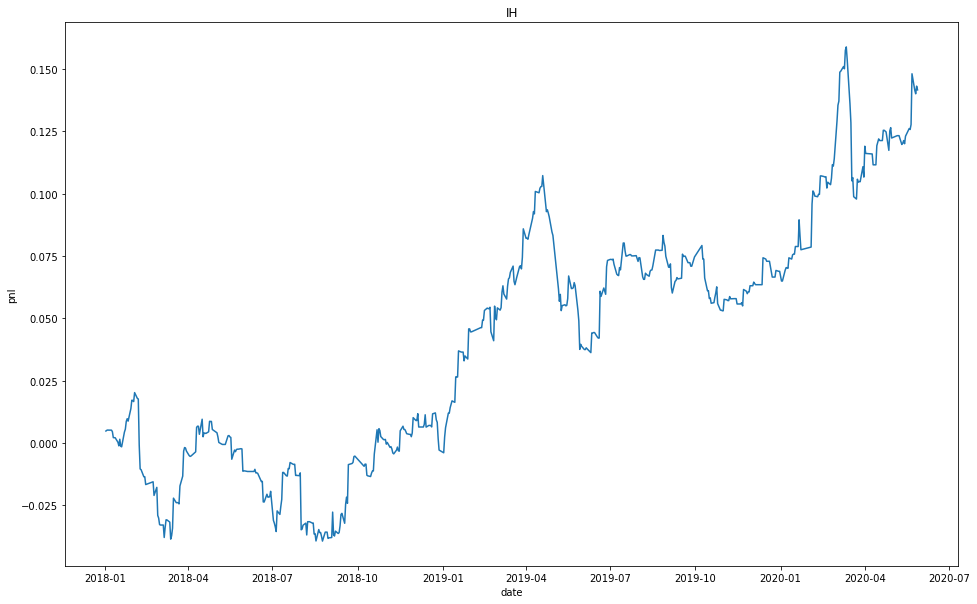

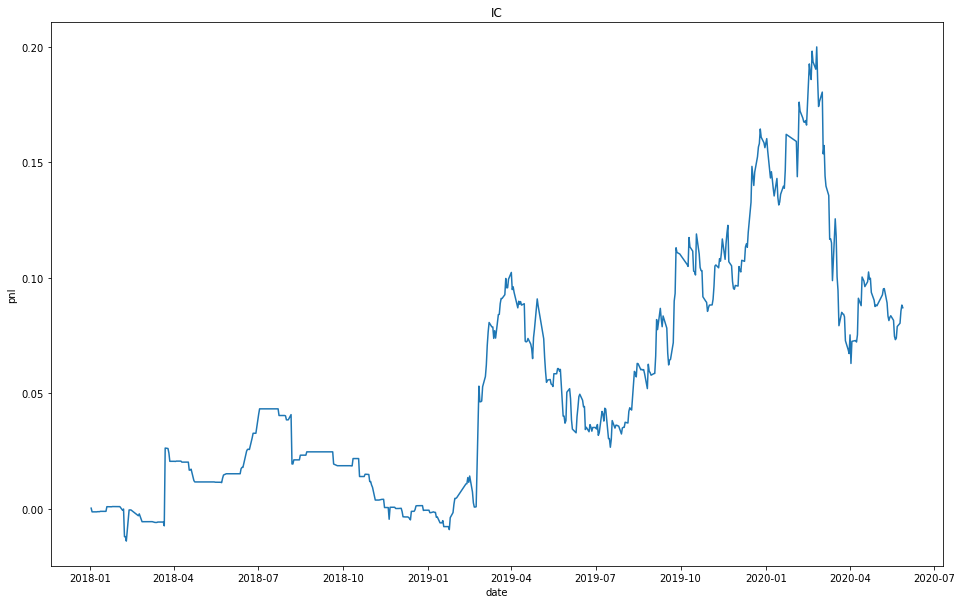

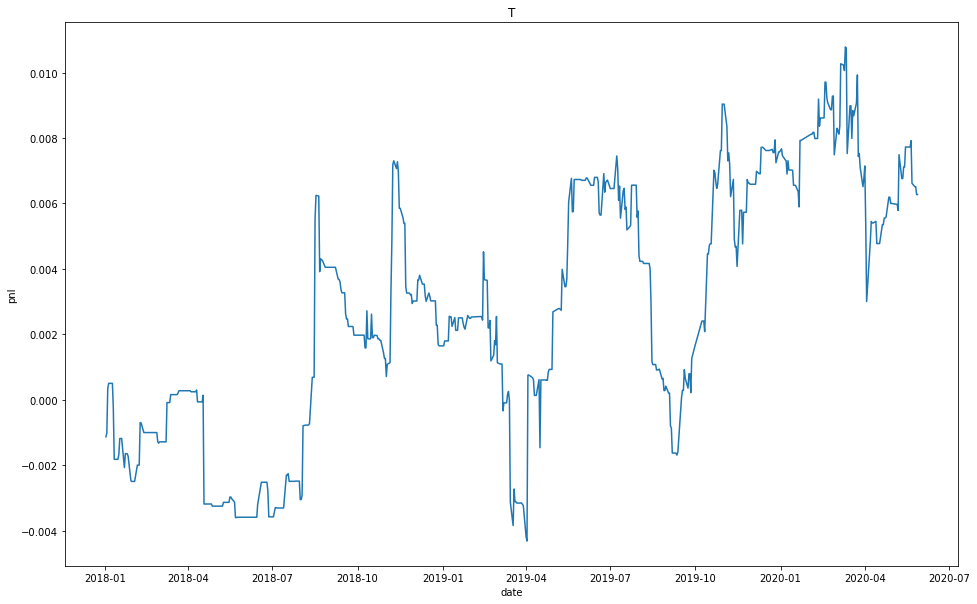

In [41]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        train_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        trade_stat = test_trade_stat[product]
        test_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates[test_sample], test_pnl.cumsum());
    
# IF train sharpe  0.5353755054538243 test sharpe  0.8568520744637977
# IH train sharpe  1.2424590311529555 test sharpe  0.8789082288628024
# IC train sharpe  0.22210808214994088 test sharpe  0.4084813121878254
# T train sharpe  1.369895717812262 test sharpe  0.24940131729662365





train sharpe  1.0185039816443597 test sharpe  1.1479371327283703


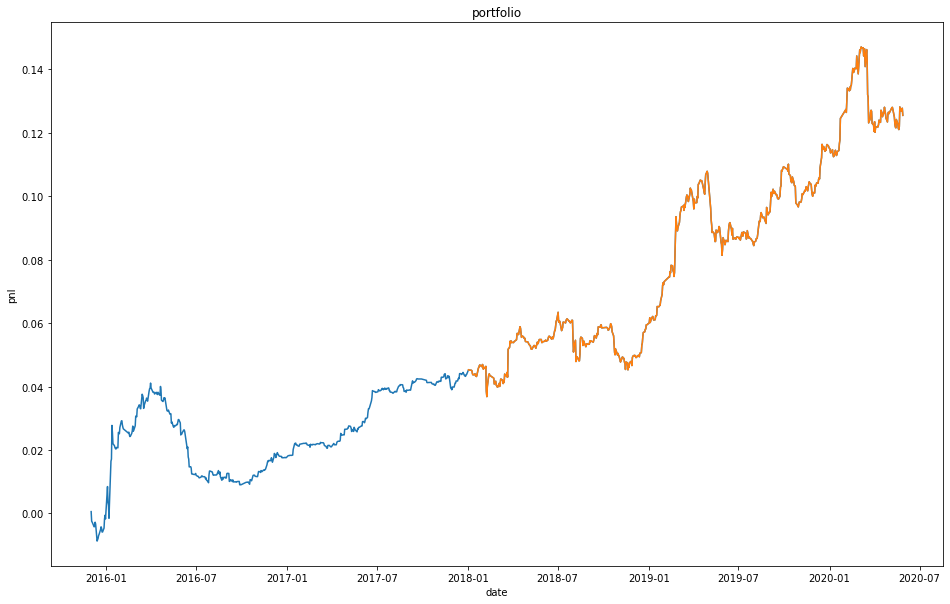

In [44]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
print("train sharpe ", sharpe(train_portfolio), "test sharpe ", sharpe(test_portfolio))
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
    

- now we see the pnl curve

In [138]:
print(sharpe(train_portfolio), sharpe(test_portfolio))
## 1.0185039816443597 1.1479371327283703

1.0185039816443597 1.1479371327283703


summary:

- i performs badly in the training set, so it doesn't have any strategies for the test sets, in which it performs well though;

- signal values differ significantly for every product, it makes parameter optimization quite difficult;

- test sets perform better than training set, but it cannot break new high for a long time recently

possible solution:
- choose strategies not based on performance, we can limit the parameters to a small range, and use risk parity to allocate weights to all of them;
- we can use Bayesian Optimization to choose parameters automatically to avoid humen intervention;
- maybe adding i can make the strategies break new high recently

we can try these solutions in the future

- at last we plot the selected pnl

- now we can combine all of these to a function

In [142]:
reverse_list = dict([])
reverse_list["IF"] = 1
reverse_list["IH"] = -1
reverse_list["IC"] = 1
reverse_list["T"] = 1
reverse_list["TF"] =1

In [147]:
atr_filter_list = dict([])
atr_filter_list["IF"] = 100
atr_filter_list["IH"] = 100
atr_filter_list["IC"] = 100
atr_filter_list["T"] = 20
atr_filter_list["TF"] = 20

In [148]:
thre_mat_list = dict([])
thre_mat_list["IF"] = index_thre_mat
thre_mat_list["IH"] = index_thre_mat
thre_mat_list["IC"] = index_thre_mat
thre_mat_list["T"] = treasury_thre_mat
thre_mat_list["TF"] = treasury_thre_mat

In [152]:
## get backtest result of a signal on a product's list
from collections import OrderedDict
def get_list_signal_stat(signal_name, thre_mat_list, product_list, all_dates, atr_filter_list,
                    split_str="2018", min_pnl=2, min_num=20, reverse=1):
    CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
    train_sample = np.array(all_dates)<split_str ## training samples
    test_sample = np.array(all_dates)>split_str ## test samples
    date_str = [n[0:8] for n in all_dates] ## date string
    format_dates = np.array([pd.to_datetime(d) for d in date_str]) ## date in xxxx-xx-xx format
    train_trade_stat = dict([]) ## training result statistics
    print("training")
    for product in product_list:
        print(product)
        spread = product_info[product]["spread"] ## get product's bid/ask spread
        tranct = product_info[product]["tranct"] ## get product's transaction cost
        tranct_ratio = product_info[product]["tranct.ratio"] ## True: tranct cost based on notional; False: fix cost
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                      reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                      HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                      atr_filter=atr_filter)
            train_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
        trade_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
        train_trade_stat[product] = trade_stat
    print("testing")
    test_trade_stat = dict([])
    for product in product_list:
        print(product)
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        thre_mat = thre_mat_list[product]
        reverse = reverse_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                     reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio,
                                      HEAD_PATH = HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                      atr_filter=atr_filter)
            result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
        trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
        test_trade_stat[product] = trade_stat
    result=dict([])
    result["train_trade_stat"] = train_trade_stat ## save train stat
    result["test_trade_stat"] = test_trade_stat ## save test stat
    if reverse==-1:
        save(result, HEAD_PATH+"/"+signal_name+".result.pkl") ## reversal strategy
    else:
        save(result, HEAD_PATH+"/"+signal_name+".pos.result.pkl") ## trend strategy

In [153]:
## get train and test result, choose good strategies, plot the portfolio and result of each product

def get_list_signal_result(signal_name, product_list, all_dates, split_str="2018", reverse=1,
                           min_pnl=2, min_num=20):
    if reverse==-1:
        result = load(HEAD_PATH+"/"+signal_name+".result.pkl") ## load reversal strat statistics
    else:
        result = load(HEAD_PATH+"/"+signal_name+".pos.result.pkl") ## load trend strat statistics
    train_trade_stat = result["train_trade_stat"]
    test_trade_stat = result["test_trade_stat"]
    train_sample = np.array(all_dates)<split_str
    test_sample = np.array(all_dates)>split_str
    date_str = [n[0:8] for n in all_dates]
    format_dates = np.array([pd.to_datetime(d) for d in date_str])
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    for product in product_list:
        spread = product_info[product]["spread"]
        trade_stat = train_trade_stat[product]
        ## two criterion: minimum averge pnl (unit is spread), monimum number of trades
        good_strat = (trade_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (trade_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>0:
            train_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            train_std = np.std(train_pnl)
            train_pnl = train_pnl/train_std
            trade_stat = test_trade_stat[product]
            test_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
            print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
            test_all_pnl[:,i] = test_pnl
            train_all_pnl[:,i] = train_pnl
            i = i+1
    if i>0:
        train_portfolio = np.array(np.mean(train_all_pnl[:,:i], axis=1))
        test_portfolio = np.array(np.mean(test_all_pnl[:,:i], axis=1))
        all_portfolio = np.append(train_portfolio, test_portfolio)
        plt.figure(1, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title("portfolio");
        plt.plot(format_dates, all_portfolio.cumsum());
        plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
        signal_stat = dict([])
        signal_stat["train.stat"] = train_trade_stat
        signal_stat["test.stat"] = test_trade_stat
        print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))

In [154]:
%%time
get_list_signal_stat("dbook.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                     split_str="2018", min_pnl=2, min_num=20, reverse=1)

# training
# IF
# IH
# IC
# T
# TF
# testing
# IF
# IH
# IC
# T
# TF
# Wall time: 31min 29s



training
IF
IH
IC
T
TF
testing
IF
IH
IC
T
TF
Wall time: 31min 29s


IF train sharpe  0.5353755054538244 test sharpe  0.8568520744637979
IC train sharpe  0.22210808214994093 test sharpe  0.40848131218782546
T train sharpe  1.3704200140557088 test sharpe  0.24334288331399315
train sharpe:  1.097350436315248 test sharpe:  0.7574931047120392


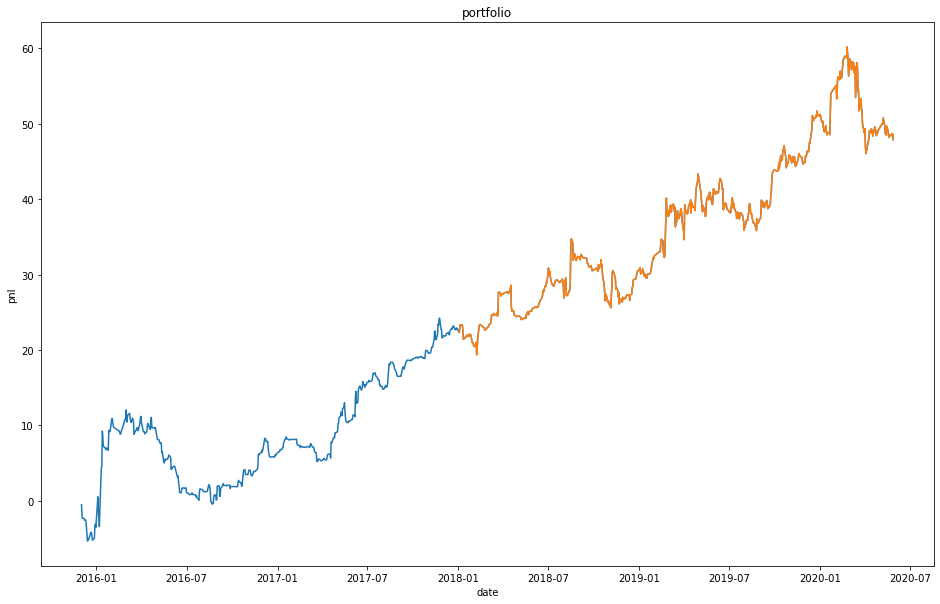

In [156]:
get_list_signal_result("dbook.4096", product_list, all_dates, split_str="2018", reverse=1,min_pnl=2, min_num=20)

# IF train sharpe  0.5353755054538244 test sharpe  0.8568520744637979
# IC train sharpe  0.22210808214994093 test sharpe  0.40848131218782546
# T train sharpe  1.3704200140557088 test sharpe  0.24334288331399315
# train sharpe:  1.097350436315248 test sharpe:  0.7574931047120392



- we can test other signals

In [158]:
## any price is between minimum and maximum
## so if we use (price-min)/(max-min), the result is between [0,1]
## 0 is min, 1 is max
## then we subtract 0.5 from it
## then result is between -0.5 to 0.5
## and finally use ewma to take the average result over a range
from collections import OrderedDict
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values

In [159]:
def get_range_pos(wpr, min_period, max_period, period):
    return ewma(zero_divide(wpr-min_period, max_period-min_period), period, adjust=True) - 0.5


- let's see waht it looks like

In [160]:
x4_1 = foctor_range_pos_period()
## we've changed it a little bit from week 2 by adding
## xs.new <- gsub(para.name, value, xs)    
## aa <- with(data,eval(parse(text=xs.new)))
## so be aware that the name of parameter should be complex enough to avoid error

- now we can create path

In [163]:
for product in product_list:
    create_signal_path(x4_1, product, SAVE_PATH)

# e:/intern/tmp pkl/IF/range.pos.1024
# e:/intern/tmp pkl/IF/range.pos.2048
# e:/intern/tmp pkl/IF/range.pos.4096
# e:/intern/tmp pkl/IH/range.pos.1024
# e:/intern/tmp pkl/IH/range.pos.2048
# e:/intern/tmp pkl/IH/range.pos.4096
# e:/intern/tmp pkl/IC/range.pos.1024
# e:/intern/tmp pkl/IC/range.pos.2048
# e:/intern/tmp pkl/IC/range.pos.4096
# e:/intern/tmp pkl/T/range.pos.1024
# e:/intern/tmp pkl/T/range.pos.2048
# e:/intern/tmp pkl/T/range.pos.4096
# e:/intern/tmp pkl/TF/range.pos.1024
# e:/intern/tmp pkl/TF/range.pos.2048
# e:/intern/tmp pkl/TF/range.pos.4096

e:/intern/tmp pkl/IF/range.pos.1024
e:/intern/tmp pkl/IF/range.pos.2048
e:/intern/tmp pkl/IF/range.pos.4096
e:/intern/tmp pkl/IH/range.pos.1024
e:/intern/tmp pkl/IH/range.pos.2048
e:/intern/tmp pkl/IH/range.pos.4096
e:/intern/tmp pkl/IC/range.pos.1024
e:/intern/tmp pkl/IC/range.pos.2048
e:/intern/tmp pkl/IC/range.pos.4096
e:/intern/tmp pkl/T/range.pos.1024
e:/intern/tmp pkl/T/range.pos.2048
e:/intern/tmp pkl/T/range.pos.4096
e:/intern/tmp pkl/TF/range.pos.1024
e:/intern/tmp pkl/TF/range.pos.2048
e:/intern/tmp pkl/TF/range.pos.4096


- then we calculate the signal

In [164]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x4_1, product=product, HEAD_PATH=SAVE_PATH)
;

# Wall time: 4min 14s


Wall time: 4min 14s


''

In [175]:
signal_name = "range.pos.4096"

In [176]:
file_list = np.array(all_dates)
n_files = len(file_list)
to_choose = (np.arange(n_files)+1) % 10 == 0
all_signal = np.array([])
for file in file_list[to_choose]:
    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
    signal = S[data["good"]]
    moving_average(signal,period)
    chosen = (np.arange(len(signal))+1) % period==0
    all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)

- then we can see how the signal looks like

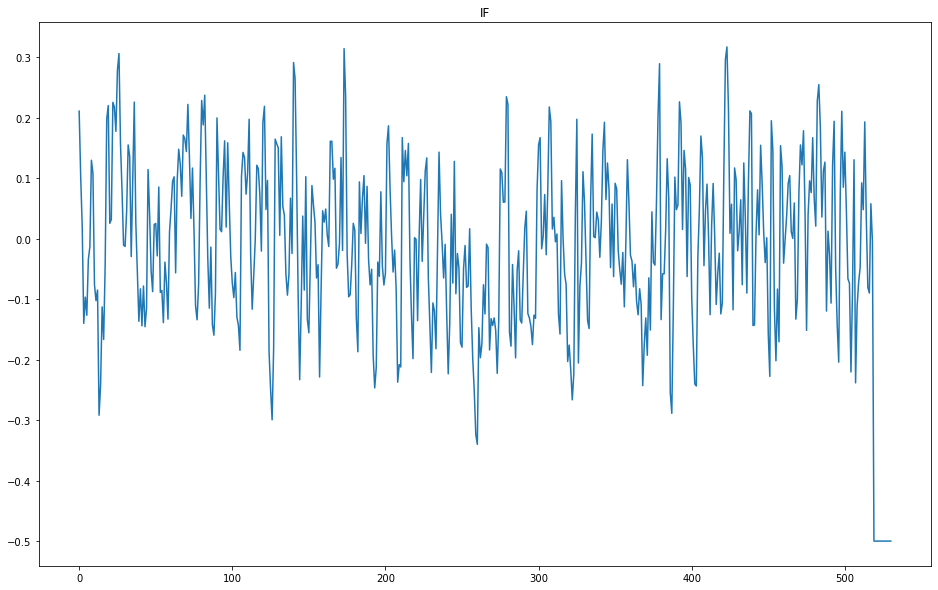

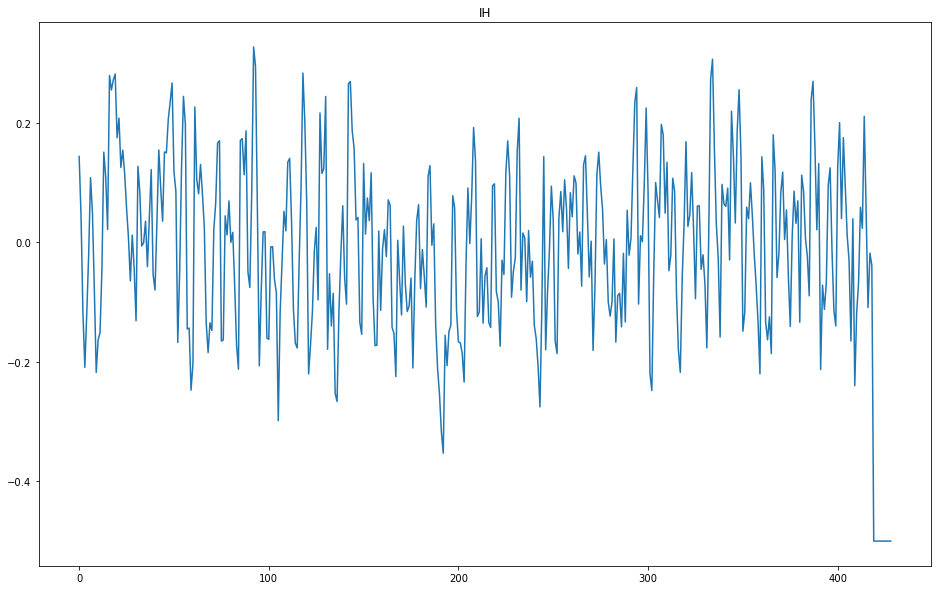

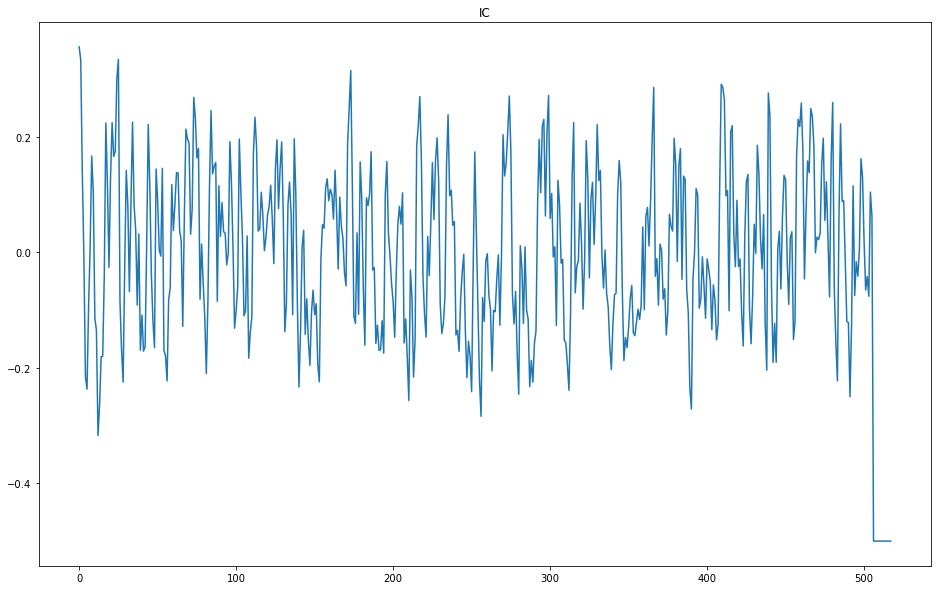

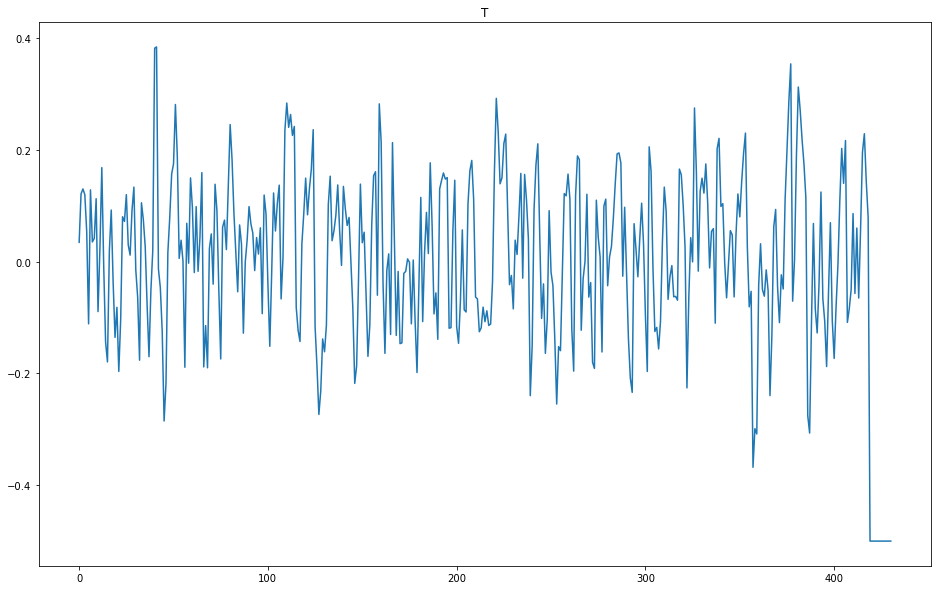

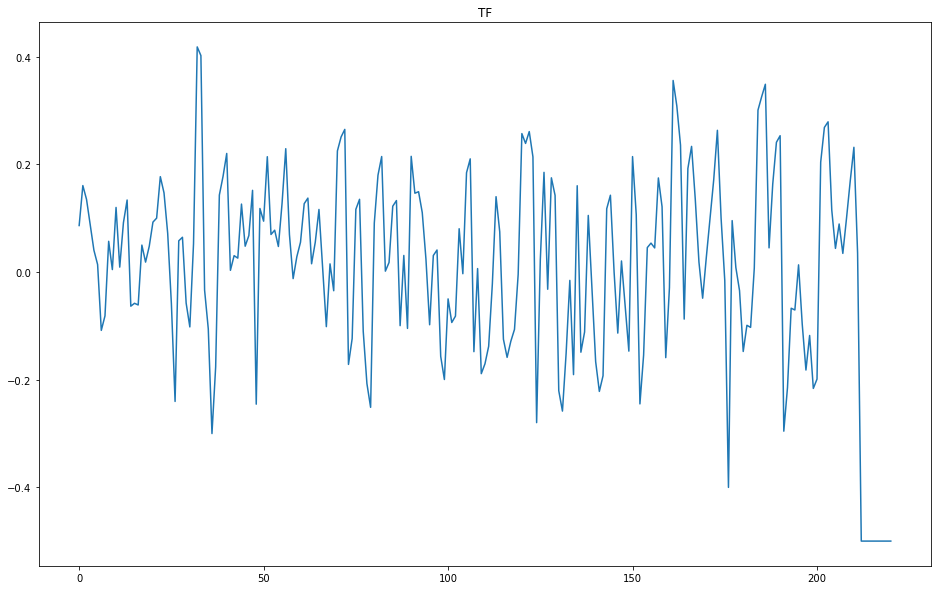

In [193]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "range.pos."+str(period), period, SIGNAL_PATH=SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- there is no extreme values

In [195]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [196]:
%%time
signal_stat = get_list_signal_stat("range.pos.4096", thre_mat_list, product_list, all_dates, atr_filter_list, 
                                   split_str="2018", min_pnl=2, min_num=20, reverse=1)

# training
# IF
# IH
# IC
# T
# TF
# testing
# IF
# IH
# IC
# T
# TF
# Wall time: 43min 37s



training
IF
IH
IC
T
TF
testing
IF
IH
IC
T
TF
Wall time: 43min 37s


IF train sharpe  0.5162389496284839 test sharpe  0.9298225727272512
IH train sharpe  0.48807967151389453 test sharpe  -1.3995538919877537
IC train sharpe  0.9464362725406602 test sharpe  1.3102667015926237
T train sharpe  0.6126824068295961 test sharpe  0.29841718627489805
TF train sharpe  0.8201503337517384 test sharpe  -0.5562492579618404
train sharpe:  1.1214520317230248 test sharpe:  0.08499477522606418


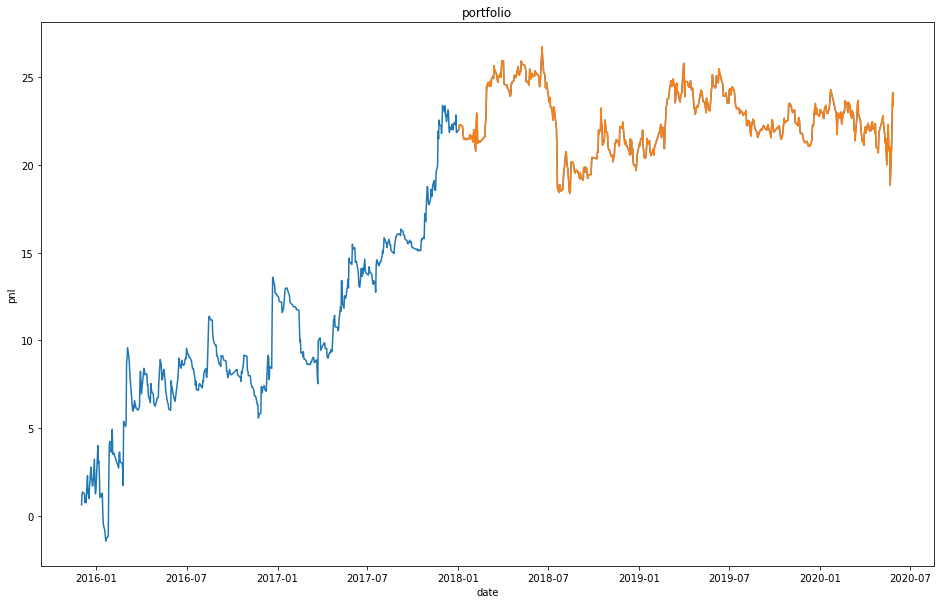

In [197]:
signal_stat = get_list_signal_result("range.pos.4096", product_list, all_dates, reverse=1, 
                                   min_pnl=2, min_num=10)

# IF train sharpe  0.5162389496284839 test sharpe  0.9298225727272512
# IH train sharpe  0.48807967151389453 test sharpe  -1.3995538919877537
# IC train sharpe  0.9464362725406602 test sharpe  1.3102667015926237
# T train sharpe  0.6126824068295961 test sharpe  0.29841718627489805
# TF train sharpe  0.8201503337517384 test sharpe  -0.5562492579618404
# train sharpe:  1.1214520317230248 test sharpe:  0.08499477522606418


In [198]:
## double moving average
## long is perio,d short is round(period/10)
## we can use this idea to consturct many combinations
from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

In [199]:
x99_1 = foctor_ma_diff_period()

In [200]:
for product in product_list:
    create_signal_path(x99_1, product, SAVE_PATH)

e:/intern/tmp pkl/IF/ma.dif.10.1024
e:/intern/tmp pkl/IF/ma.dif.10.2048
e:/intern/tmp pkl/IF/ma.dif.10.4096
e:/intern/tmp pkl/IH/ma.dif.10.1024
e:/intern/tmp pkl/IH/ma.dif.10.2048
e:/intern/tmp pkl/IH/ma.dif.10.4096
e:/intern/tmp pkl/IC/ma.dif.10.1024
e:/intern/tmp pkl/IC/ma.dif.10.2048
e:/intern/tmp pkl/IC/ma.dif.10.4096
e:/intern/tmp pkl/T/ma.dif.10.1024
e:/intern/tmp pkl/T/ma.dif.10.2048
e:/intern/tmp pkl/T/ma.dif.10.4096
e:/intern/tmp pkl/TF/ma.dif.10.1024
e:/intern/tmp pkl/TF/ma.dif.10.2048
e:/intern/tmp pkl/TF/ma.dif.10.4096


In [201]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x99_1, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 5min 8s


Wall time: 5min 8s


''

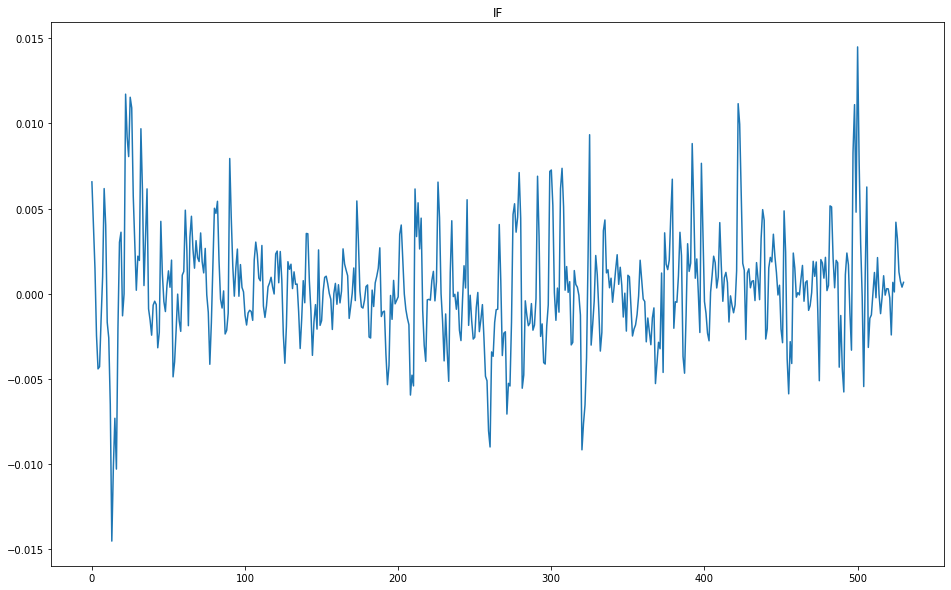

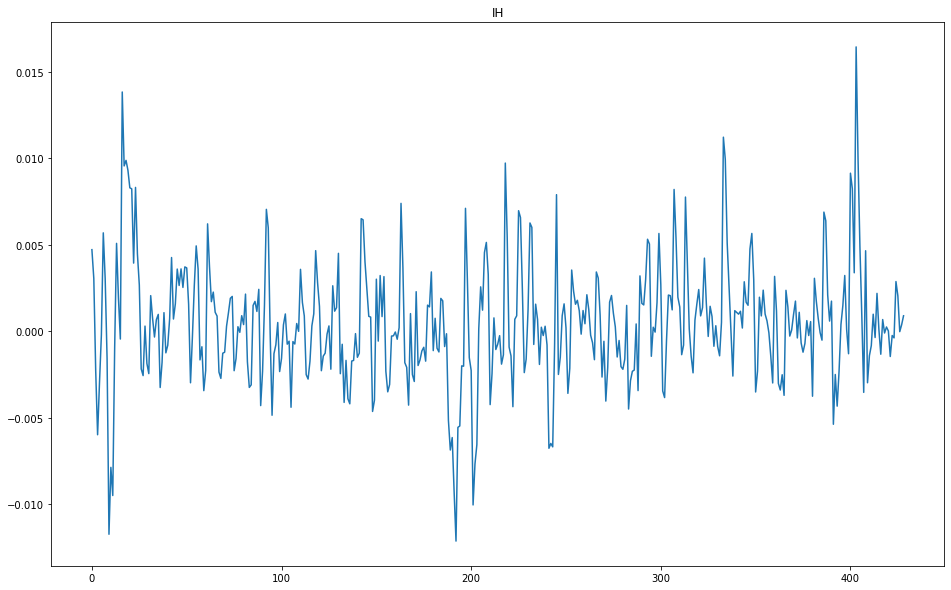

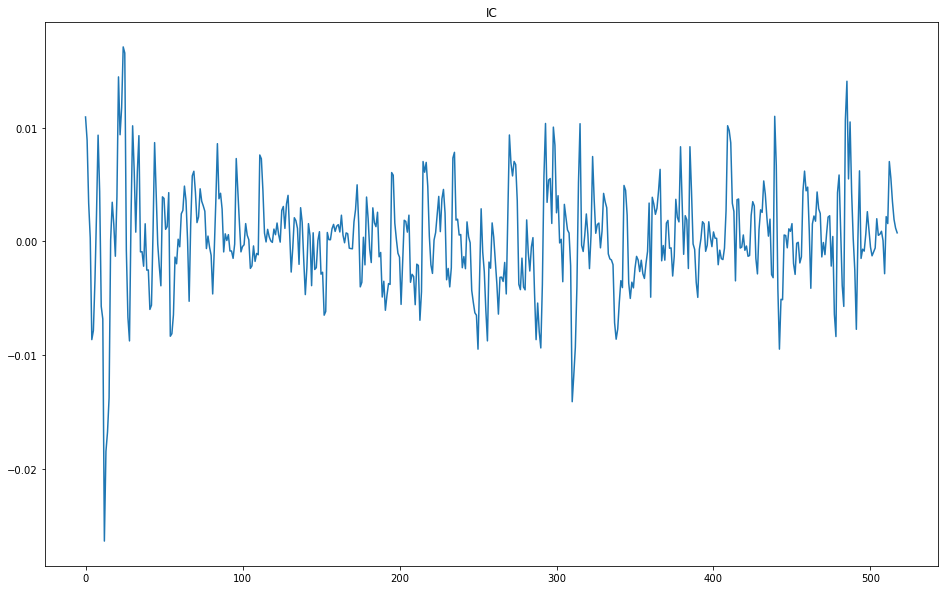

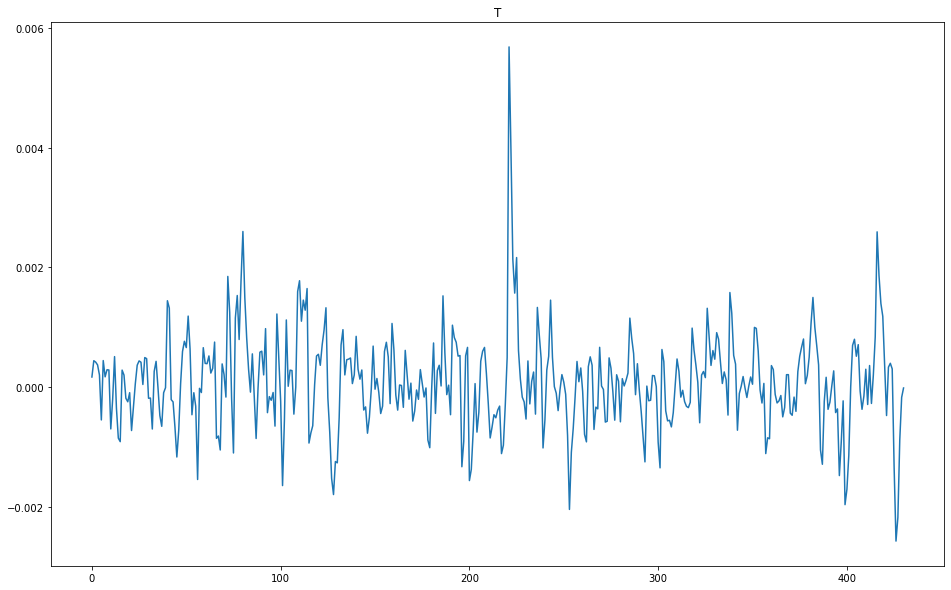

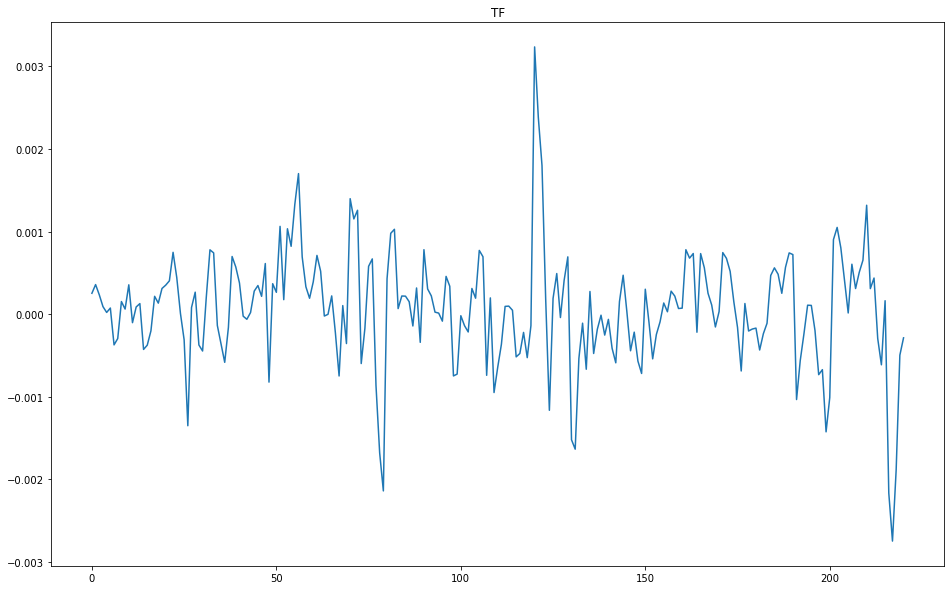

In [211]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "ma.dif.10."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [204]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.005, 0.015, 0.0005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in ["IF","IH","IC"]:
    thre_mat_list[product] = thre_mat
open_list = np.arange(0.001, 0.003, 0.0001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in ["T", "TF"]:
    thre_mat_list[product] = thre_mat


In [205]:
%%time
signal_stat = get_list_signal_stat("ma.dif.10.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="2018", min_pnl=2, min_num=20, reverse=1)

# training
# IF
# IH
# IC
# T
# TF
# testing
# IF
# IH
# IC
# T
# TF
# Wall time: 19min 2s


training
IF
IH
IC
T
TF
testing
IF
IH
IC
T
TF
Wall time: 19min 2s


IF train sharpe  0.9237898644246391 test sharpe  0.29311341619022324
IH train sharpe  0.42136041712250055 test sharpe  -0.5532368269302431
IC train sharpe  0.9775926185360179 test sharpe  0.10498261456683561
T train sharpe  0.6392709389737955 test sharpe  0.07271563508258443
TF train sharpe  0.3322517648695254 test sharpe  -0.6684891554264397
train sharpe:  0.9978944922696315 test sharpe:  -0.4411576021389636


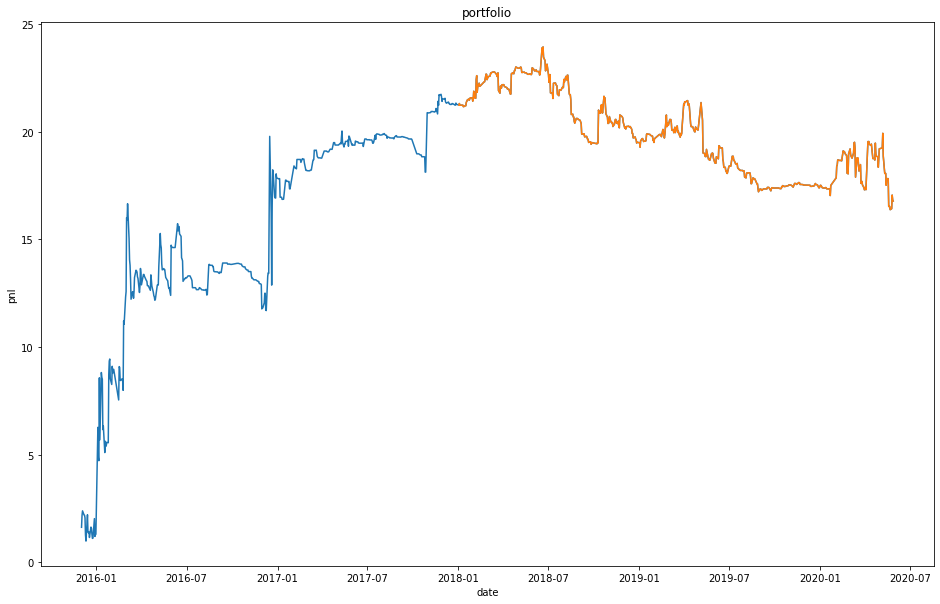

In [206]:
signal_stat = get_list_signal_result("ma.dif.10.4096", product_list, all_dates, reverse=1, 
                                   min_pnl=2, min_num=20)

# IF train sharpe  0.9237898644246391 test sharpe  0.29311341619022324
# IH train sharpe  0.42136041712250055 test sharpe  -0.5532368269302431
# IC train sharpe  0.9775926185360179 test sharpe  0.10498261456683561
# T train sharpe  0.6392709389737955 test sharpe  0.07271563508258443
# TF train sharpe  0.3322517648695254 test sharpe  -0.6684891554264397
# train sharpe:  0.9978944922696315 test sharpe:  -0.4411576021389636





In [208]:
## similar to double ewma
## but divided by price range
## and short period is round(period/20)
## for exampl.e period/2, period/4, period/8...
## now period = 4096 =2^12, 
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

In [209]:
x113 = foctor_price_osci_period()
for product in product_list:
    create_signal_path(x113, product, SAVE_PATH)

e:/intern/tmp pkl/IF/price.osci.1024
e:/intern/tmp pkl/IF/price.osci.2048
e:/intern/tmp pkl/IF/price.osci.4096
e:/intern/tmp pkl/IH/price.osci.1024
e:/intern/tmp pkl/IH/price.osci.2048
e:/intern/tmp pkl/IH/price.osci.4096
e:/intern/tmp pkl/IC/price.osci.1024
e:/intern/tmp pkl/IC/price.osci.2048
e:/intern/tmp pkl/IC/price.osci.4096
e:/intern/tmp pkl/T/price.osci.1024
e:/intern/tmp pkl/T/price.osci.2048
e:/intern/tmp pkl/T/price.osci.4096
e:/intern/tmp pkl/TF/price.osci.1024
e:/intern/tmp pkl/TF/price.osci.2048
e:/intern/tmp pkl/TF/price.osci.4096


In [210]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x113, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 5min 12s

Wall time: 5min 12s


''

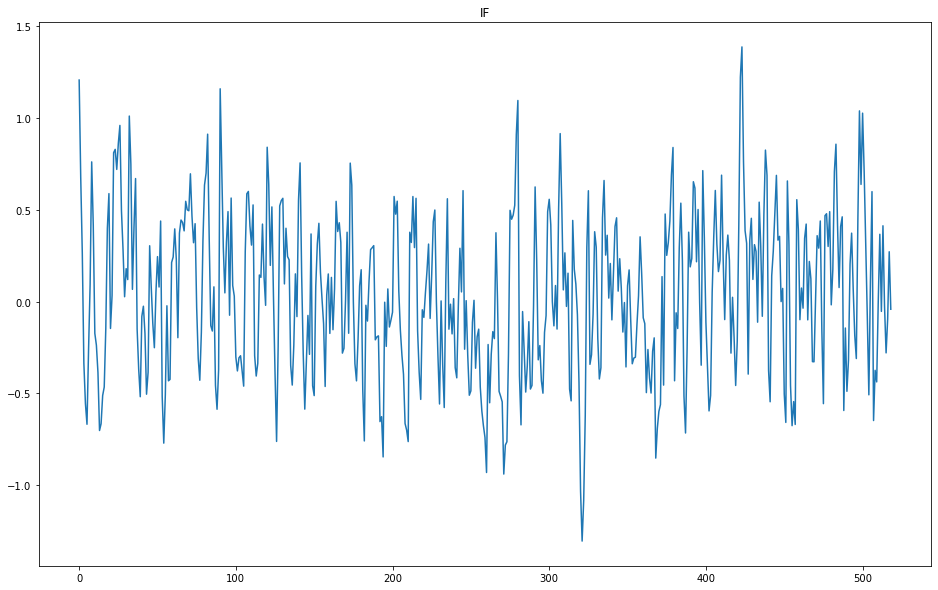

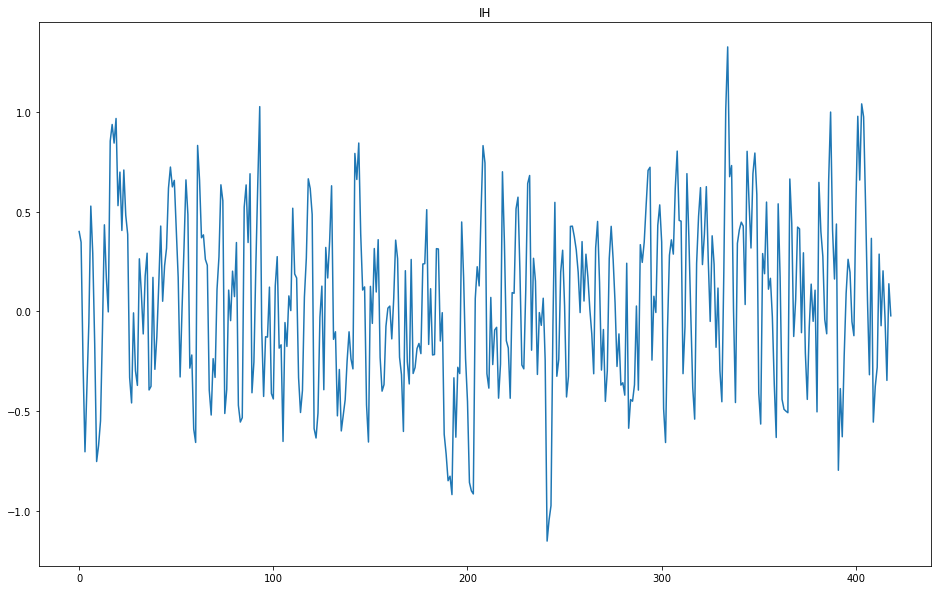

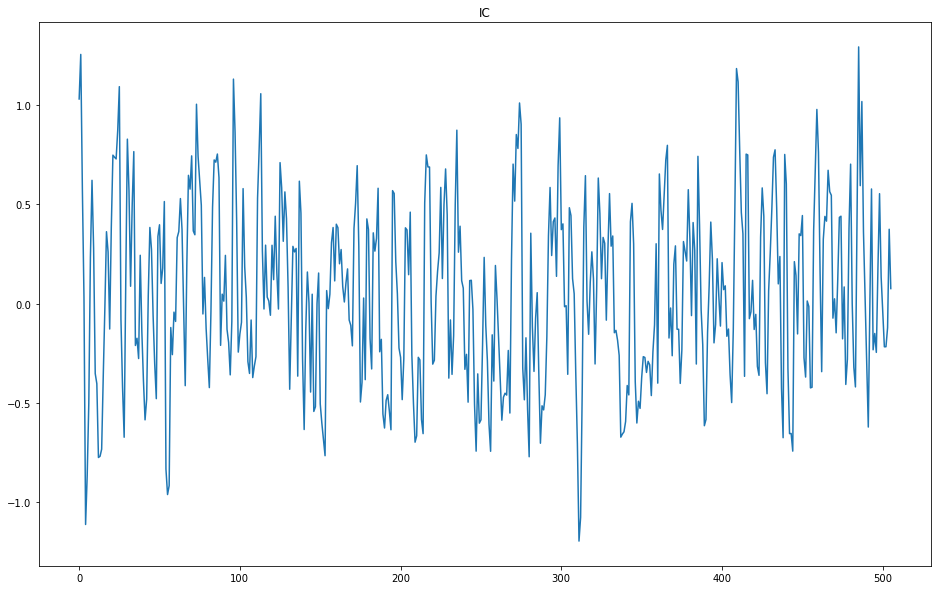

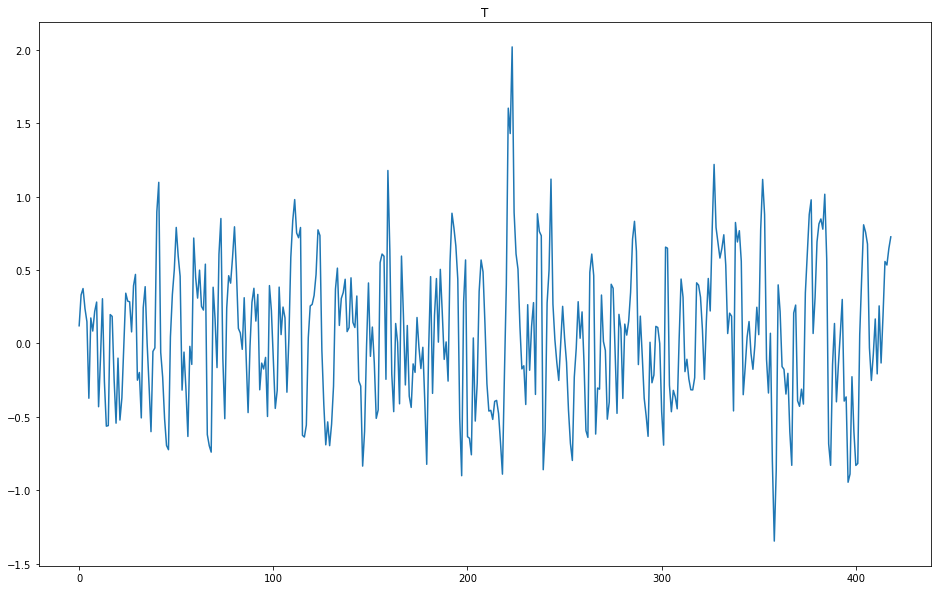

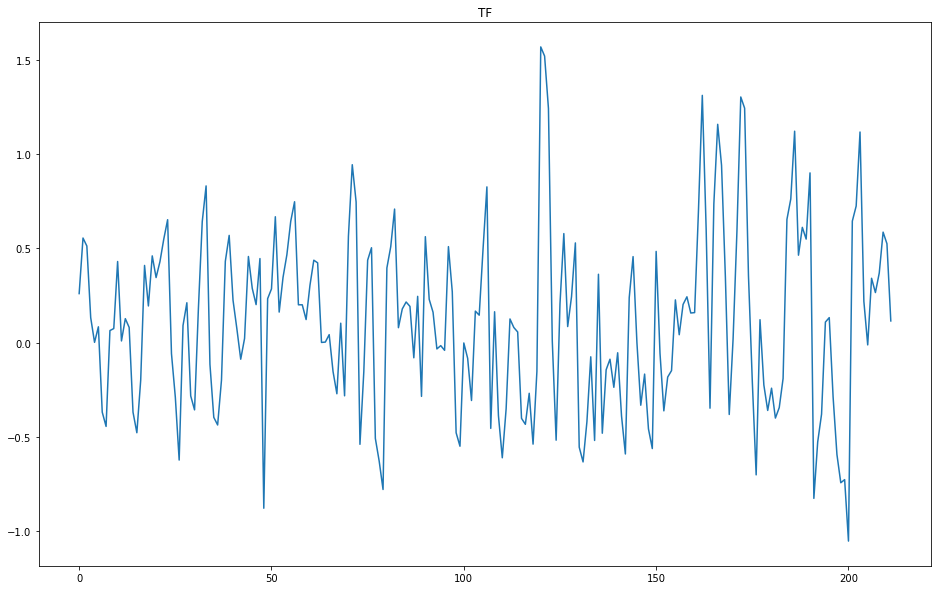

In [212]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "price.osci."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- before the last signal, let's do some analysis of skewness and kurtosis

In [214]:
from collections import OrderedDict
import itertools
open_list = np.arange(1, 2, 0.05)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat


In [215]:
%%time

signal_stat = get_list_signal_stat("price.osci.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="2018", min_pnl=2, min_num=20, reverse=1)

# training
# IF
# IH
# IC
# T
# TF
# testing
# IF
# IH
# IC
# T
# TF
# Wall time: 8min 3s


training
IF
IH
IC
T
TF
testing
IF
IH
IC
T
TF
Wall time: 8min 3s


IF train sharpe  0.3009752375251573 test sharpe  0.9233309231460589
IC train sharpe  1.1255656681836441 test sharpe  0.9991895222207934
T train sharpe  1.0478552468548252 test sharpe  1.0862210745539567
TF train sharpe  0.8547903814141526 test sharpe  0.22358307335263836
train sharpe:  1.2869145187091788 test sharpe:  1.2623654292036743
Wall time: 302 ms


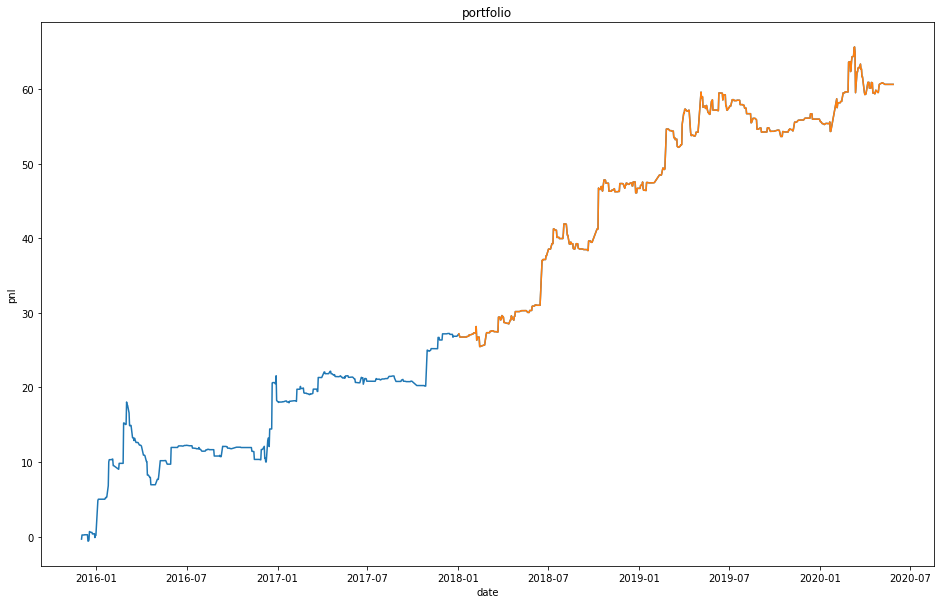

In [216]:
%%time
signal_stat = get_list_signal_result("price.osci.4096", product_list, all_dates, reverse=1, min_pnl=2, min_num=20)
# IF train sharpe  0.3009752375251573 test sharpe  0.9233309231460589
# IC train sharpe  1.1255656681836441 test sharpe  0.9991895222207934
# T train sharpe  1.0478552468548252 test sharpe  1.0862210745539567
# TF train sharpe  0.8547903814141526 test sharpe  0.22358307335263836
# train sharpe:  1.2869145187091788 test sharpe:  1.2623654292036743
# Wall time: 302 ms



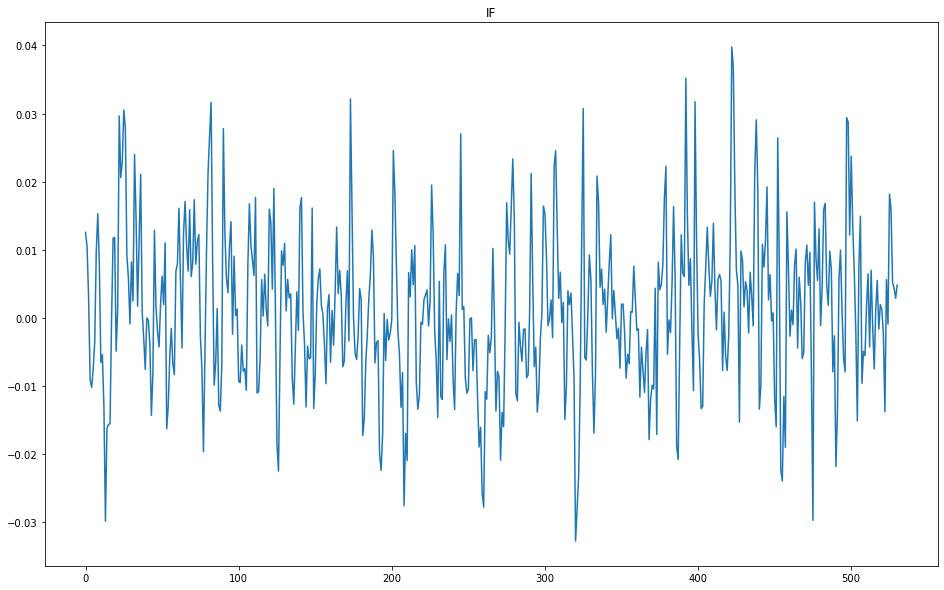

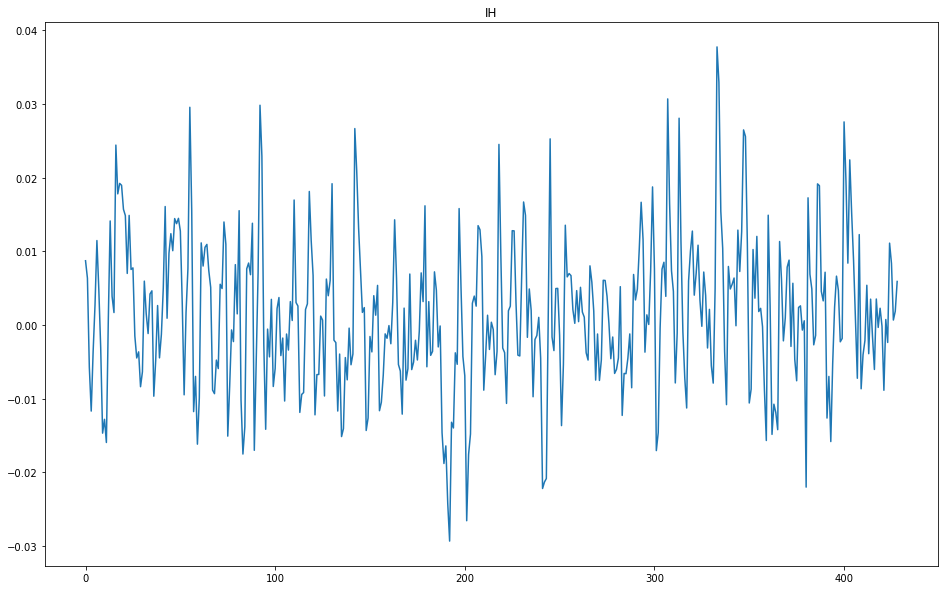

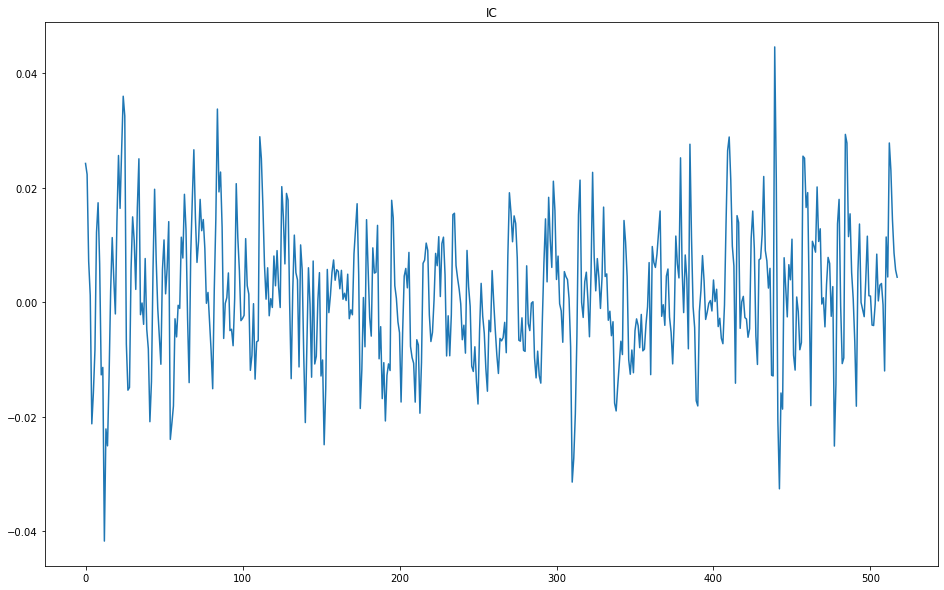

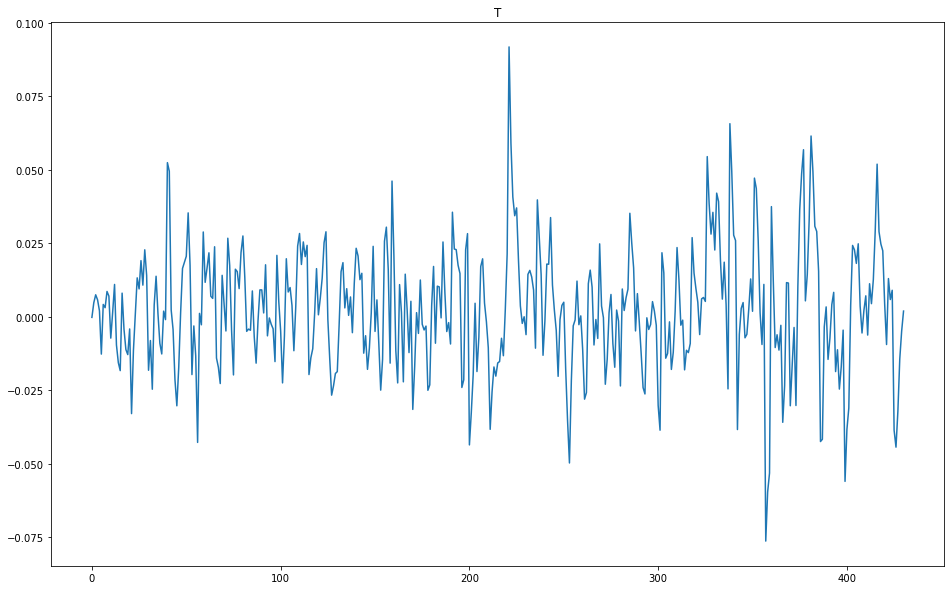

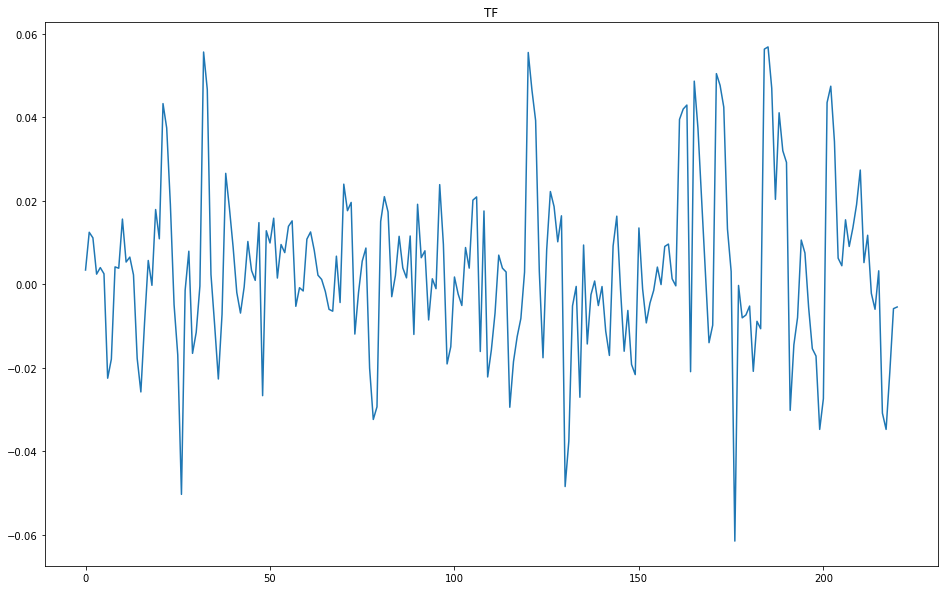

In [218]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "nr."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [219]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.02, 0.04, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in ["IF","IH","IC"]:
    thre_mat_list[product] = thre_mat
open_list = np.arange(0.04, 0.06, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in ["T", "TF"]:
    thre_mat_list[product] = thre_mat

In [220]:
%%time
signal_stat = get_list_signal_stat("nr.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="2018", min_pnl=2, min_num=20, reverse=1)

# training
# IF
# IH
# IC
# T
# TF
# testing
# IF
# IH
# IC
# T
# TF
# Wall time: 32min 21s

training
IF
IH
IC
T
TF
testing
IF
IH
IC
T
TF
Wall time: 32min 21s


IH train sharpe  0.093088414151763 test sharpe  -0.6145013863178773
IC train sharpe  0.6967769946861588 test sharpe  0.47477531014178254
T train sharpe  0.43117327423003826 test sharpe  -0.2239749025046383
train sharpe:  0.6252039618523506 test sharpe:  -0.46287116189322247
Wall time: 329 ms


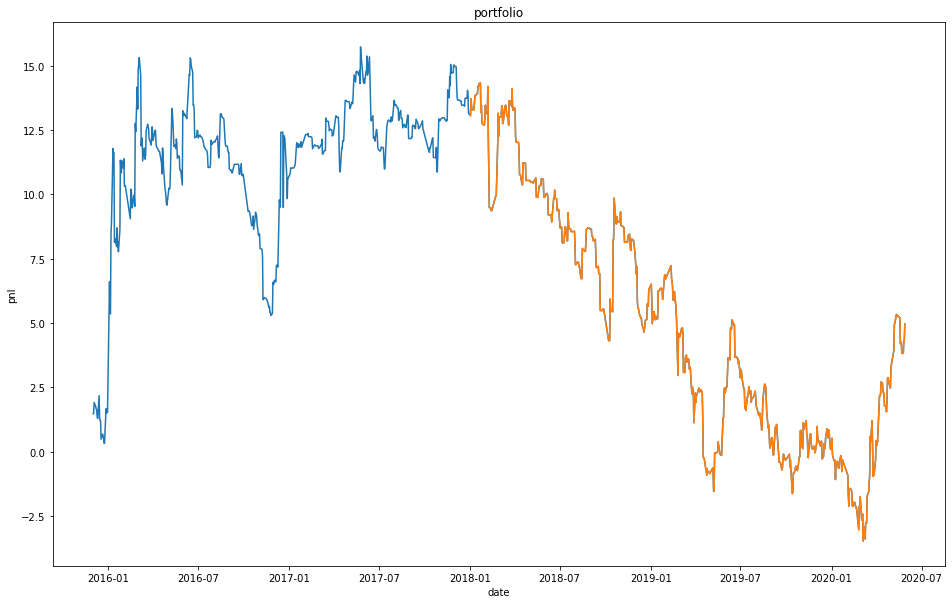

In [221]:
%%time
signal_stat = get_list_signal_result("nr.4096", product_list, all_dates, reverse=1, min_pnl=2, min_num=20)

# IH train sharpe  0.093088414151763 test sharpe  -0.6145013863178773
# IC train sharpe  0.6967769946861588 test sharpe  0.47477531014178254
# T train sharpe  0.43117327423003826 test sharpe  -0.2239749025046383
# train sharpe:  0.6252039618523506 test sharpe:  -0.46287116189322247
# Wall time: 329 ms


In [256]:
from scipy.stats import kurtosis
from scipy.stats import skew
def get_signal_moment(signal, all_dates, product_list, period):
    for product in product_list:
        all_signal = get_all_signal(np.array(all_dates), product, signal+"."+str(period), period, SIGNAL_PATH=SAVE_PATH)
        all_signal = all_signal[np.isnan(all_signal)==False]
        print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

In [227]:
%%time
get_signal_moment("dbook", all_dates, product_list, 4096)
# IF kurtosis= 3.911104437269898  skew= -0.26710467991254
# IH kurtosis= 3.7744445148090073  skew= 0.2073981223274705
# IC kurtosis= 6.427030599331551  skew= 0.7513365487479965
# T kurtosis= 6.936549096575552  skew= -0.5570541626838486
# TF kurtosis= 5.197527714386088  skew= 0.49752459307541946
# Wall time: 1min 27s


IF kurtosis= 3.911104437269898  skew= -0.26710467991254
IH kurtosis= 3.7744445148090073  skew= 0.2073981223274705
IC kurtosis= 6.427030599331551  skew= 0.7513365487479965
T kurtosis= 6.936549096575552  skew= -0.5570541626838486
TF kurtosis= 5.197527714386088  skew= 0.49752459307541946
Wall time: 1min 27s


In [228]:
%%time
get_signal_moment("range.pos", all_dates, product_list, 4096)

# IF kurtosis= 4.150527508877063  skew= -0.6335861685708338
# IH kurtosis= 4.0206727575377466  skew= -0.5894393277609894
# IC kurtosis= 3.831508576920351  skew= -0.5219935899046966
# T kurtosis= 4.467820276402233  skew= -0.7948101734736482
# TF kurtosis= 3.773178313444342  skew= -0.7198111493584642
# Wall time: 1min 31s


IF kurtosis= 4.150527508877063  skew= -0.6335861685708338
IH kurtosis= 4.0206727575377466  skew= -0.5894393277609894
IC kurtosis= 3.831508576920351  skew= -0.5219935899046966
T kurtosis= 4.467820276402233  skew= -0.7948101734736482
TF kurtosis= 3.773178313444342  skew= -0.7198111493584642
Wall time: 1min 31s


In [229]:
%%time
get_signal_moment("ma.dif.10", all_dates, product_list, 4096)

# IF kurtosis= 5.224504103283303  skew= 0.32140720736185724
# IH kurtosis= 5.206781863377674  skew= 0.4022975801791632
# IC kurtosis= 6.564569234520629  skew= -0.34366451107179424
# T kurtosis= 9.620556399061389  skew= 1.0281639470673876
# TF kurtosis= 6.655156955701812  skew= -0.1392014079176305
# Wall time: 1min 12s



IF kurtosis= 5.224504103283303  skew= 0.32140720736185724
IH kurtosis= 5.206781863377674  skew= 0.4022975801791632
IC kurtosis= 6.564569234520629  skew= -0.34366451107179424
T kurtosis= 9.620556399061389  skew= 1.0281639470673876
TF kurtosis= 6.655156955701812  skew= -0.1392014079176305
Wall time: 1min 12s


In [257]:
%%time
get_signal_moment("price.osci", all_dates, product_list, 4096)

# IF kurtosis= 2.6200816749429623  skew= 0.06881333429972432
# IH kurtosis= 2.504931592491149  skew= 0.016252370265054137
# IC kurtosis= 2.4799731208817053  skew= 0.09632735461577793
# T kurtosis= 3.038092244514751  skew= 0.23623930951118197
# TF kurtosis= 3.0808263435580128  skew= 0.34088927213605663
# Wall time: 1min 12s



IF kurtosis= 2.6200816749429623  skew= 0.06881333429972432
IH kurtosis= 2.504931592491149  skew= 0.016252370265054137
IC kurtosis= 2.4799731208817053  skew= 0.09632735461577793
T kurtosis= 3.038092244514751  skew= 0.23623930951118197
TF kurtosis= 3.0808263435580128  skew= 0.34088927213605663
Wall time: 1min 12s


In [258]:
%%time
get_signal_moment("nr", all_dates, product_list, 4096)

# IF kurtosis= 3.4188185312967483  skew= 0.21192359771140812
# IH kurtosis= 3.5514754932492343  skew= 0.2838154022001089
# IC kurtosis= 3.482873483879607  skew= 0.11680346006341671
# T kurtosis= 4.192300455744943  skew= 0.1323395533460339
# TF kurtosis= 3.6994739999403023  skew= 0.2760746741420807
# Wall time: 1min 12s



IF kurtosis= 3.4188185312967483  skew= 0.21192359771140812
IH kurtosis= 3.5514754932492343  skew= 0.2838154022001089
IC kurtosis= 3.482873483879607  skew= 0.11680346006341671
T kurtosis= 4.192300455744943  skew= 0.1323395533460339
TF kurtosis= 3.6994739999403023  skew= 0.2760746741420807
Wall time: 1min 12s


In [259]:
class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                   adjust=True).values
    

In [260]:
x11 = foctor_kdj_k_period()
for product in product_list:
    create_signal_path(x11, product, SAVE_PATH)

e:/intern/tmp pkl/IF/kdj.k.1024
e:/intern/tmp pkl/IF/kdj.k.2048
e:/intern/tmp pkl/IF/kdj.k.4096
e:/intern/tmp pkl/IH/kdj.k.1024
e:/intern/tmp pkl/IH/kdj.k.2048
e:/intern/tmp pkl/IH/kdj.k.4096
e:/intern/tmp pkl/IC/kdj.k.1024
e:/intern/tmp pkl/IC/kdj.k.2048
e:/intern/tmp pkl/IC/kdj.k.4096
e:/intern/tmp pkl/T/kdj.k.1024
e:/intern/tmp pkl/T/kdj.k.2048
e:/intern/tmp pkl/T/kdj.k.4096
e:/intern/tmp pkl/TF/kdj.k.1024
e:/intern/tmp pkl/TF/kdj.k.2048
e:/intern/tmp pkl/TF/kdj.k.4096


In [261]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x11, product=product, HEAD_PATH=SAVE_PATH)
;

#Wall time: 4min 19s


Wall time: 4min 19s


''

IF kurtosis= 2.0411822052707334  skew= 0.10431731426429683
IH kurtosis= 2.0530537973524536  skew= 0.023323538728314393
IC kurtosis= 1.9564028746396158  skew= 0.0755795885566464
T kurtosis= 1.9376923399568098  skew= -0.0041956586964213465
TF kurtosis= 1.974339795246715  skew= -0.05710955667095661


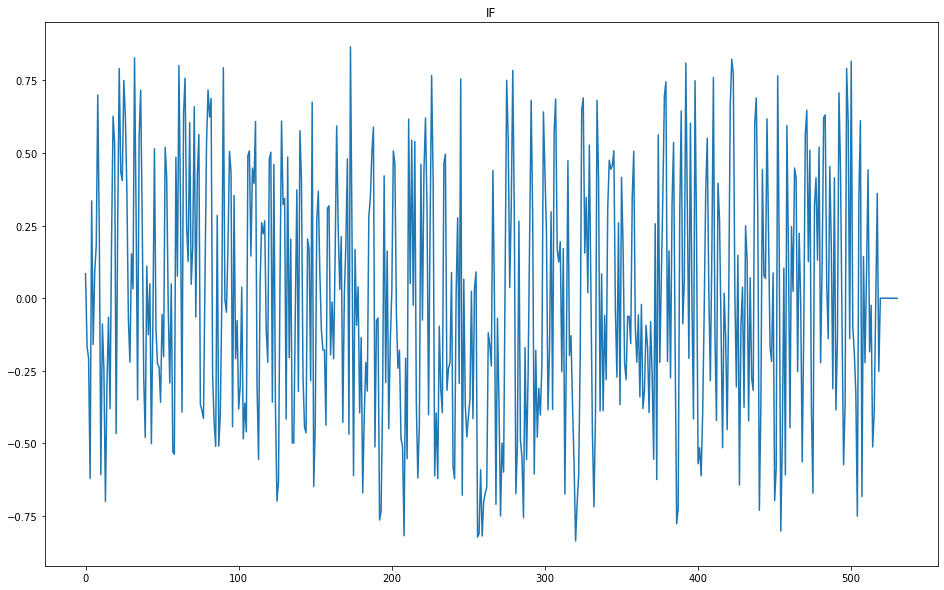

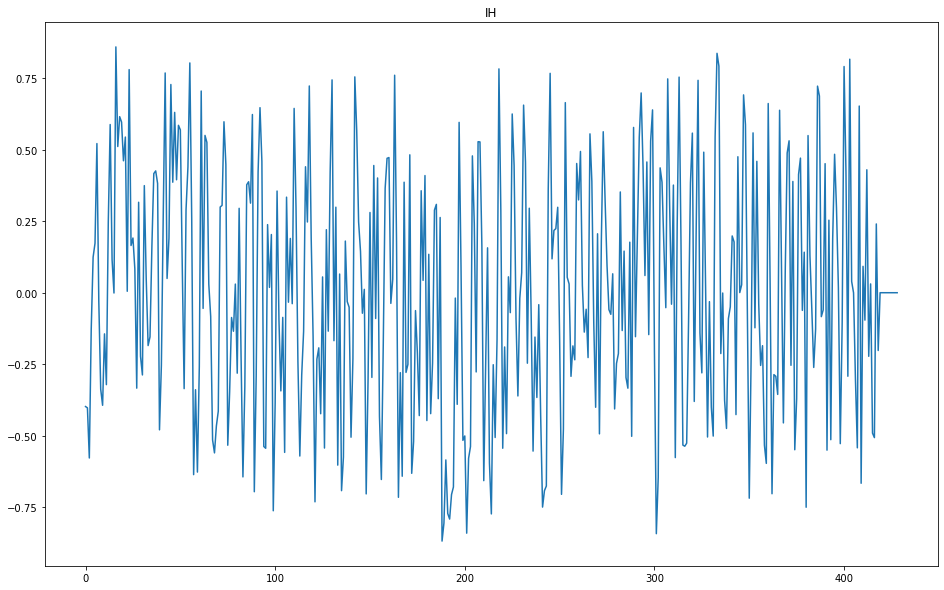

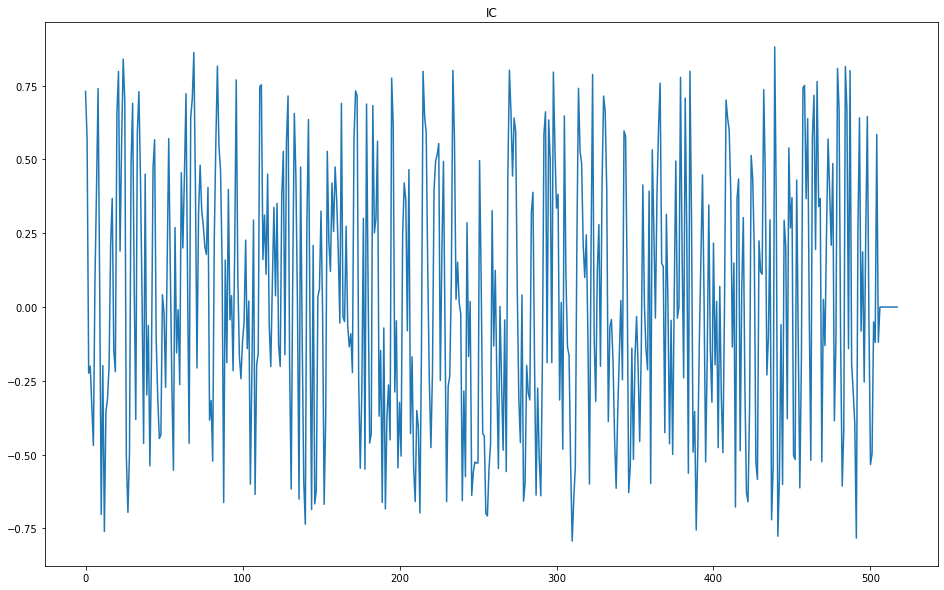

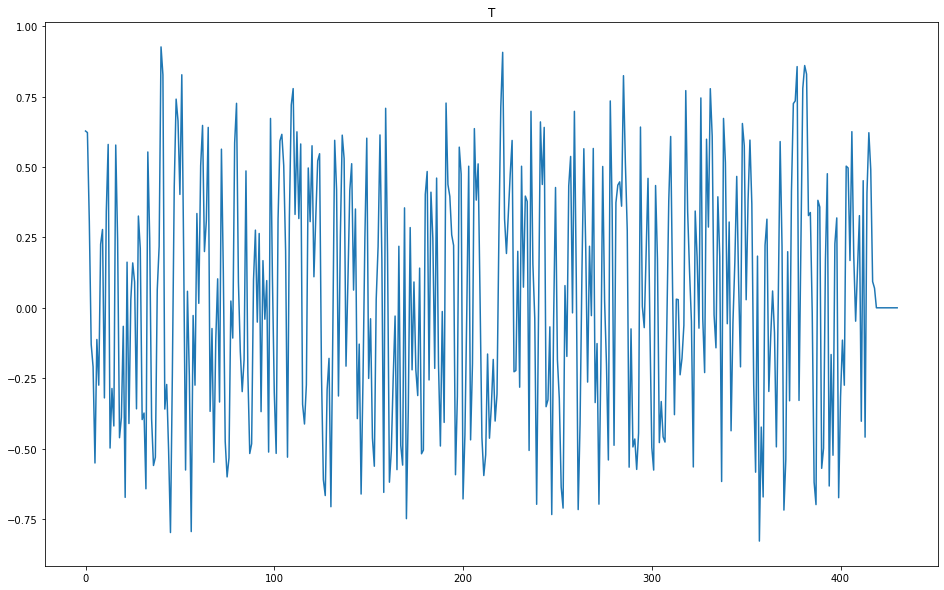

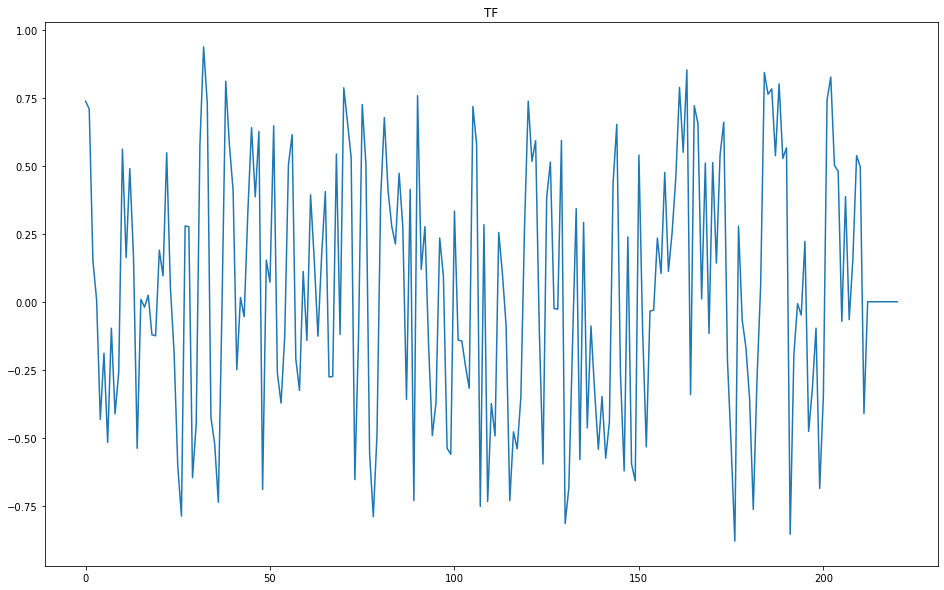

In [262]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.k."+str(period), period,HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

# IF kurtosis= 2.0411822052707334  skew= 0.10431731426429683
# IH kurtosis= 2.0530537973524536  skew= 0.023323538728314393
# IC kurtosis= 1.9564028746396158  skew= 0.0755795885566464
# T kurtosis= 1.9376923399568098  skew= -0.0041956586964213465
# TF kurtosis= 1.974339795246715  skew= -0.05710955667095661


- we know that standard normal distribution is 3, so 3.29 is a little bit higher but still close to normal distribution
- as we see above, range.pos.signal and dbook.signal are good signals, they have kurtosis of slightly above 3
- open.int.ret.signal and nr.signal are not good signals, and they have kurtosis above 8
- nr.vanish.signal is better than nr.signal, and it has kurtosis much lower
- so when we want to improve our signals, we can focus on how to decrease the kurtosis


- kurtosis is used to measure fatness and thiness of the shape of the density distribution
- financial has fat tails, which may lead to large kurtosis value
- so we can use vanish techniques to reduce it 

In [263]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [264]:
%%time
signal_stat = get_list_signal_stat("kdj.k.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str = "2018", min_pnl=2, min_num=20,reverse=1)
# training
# IF
# IH
# IC
# T
# TF
# testing
# IF
# IH
# IC
# T
# TF
# Wall time: 38min 15s


training
IF
IH
IC
T
TF
testing
IF
IH
IC
T
TF
Wall time: 38min 15s


IF train sharpe  1.0128712191492801 test sharpe  1.1149830115739332
IH train sharpe  0.738229779902322 test sharpe  -1.6231604469640535
IC train sharpe  0.9467963640553361 test sharpe  0.4916662581616393
TF train sharpe  0.7296743739355137 test sharpe  -0.16639043615084181
train sharpe:  1.2411697455407202 test sharpe:  -0.28815309565656694
Wall time: 375 ms


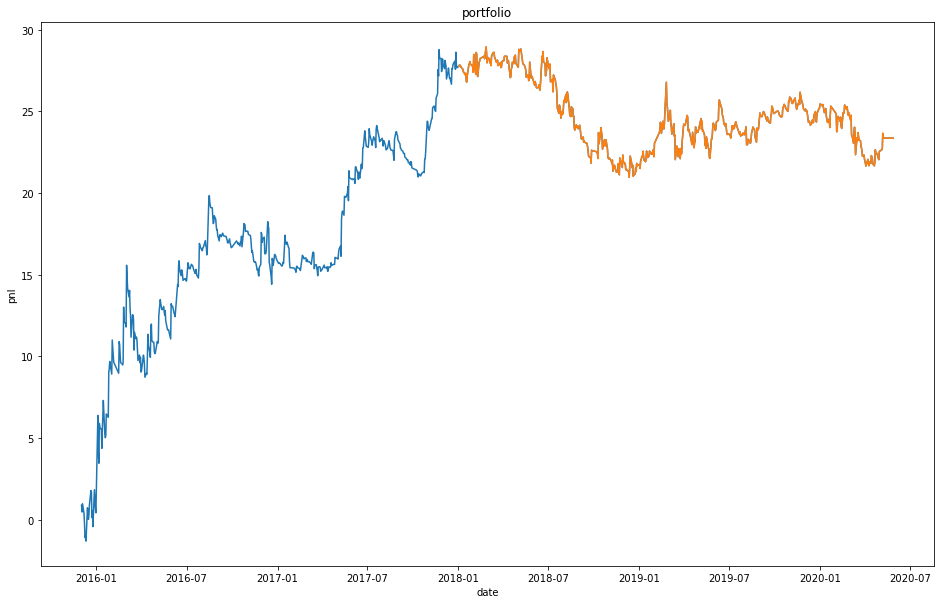

In [265]:
%%time
signal_stat = get_list_signal_result("kdj.k.4096", product_list, all_dates, reverse=1, min_pnl=2, min_num=20)

# IF train sharpe  1.0128712191492801 test sharpe  1.1149830115739332
# IH train sharpe  0.738229779902322 test sharpe  -1.6231604469640535
# IC train sharpe  0.9467963640553361 test sharpe  0.4916662581616393
# TF train sharpe  0.7296743739355137 test sharpe  -0.16639043615084181
# train sharpe:  1.2411697455407202 test sharpe:  -0.28815309565656694
# Wall time: 375 ms



In [266]:
class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                        adjust=True), round(period/5), adjust=True).values
    


In [267]:
x12 = foctor_kdj_j_period()
for product in product_list:
    create_signal_path(x12, product, SAVE_PATH)

e:/intern/tmp pkl/IF/kdj.j.1024
e:/intern/tmp pkl/IF/kdj.j.2048
e:/intern/tmp pkl/IF/kdj.j.4096
e:/intern/tmp pkl/IH/kdj.j.1024
e:/intern/tmp pkl/IH/kdj.j.2048
e:/intern/tmp pkl/IH/kdj.j.4096
e:/intern/tmp pkl/IC/kdj.j.1024
e:/intern/tmp pkl/IC/kdj.j.2048
e:/intern/tmp pkl/IC/kdj.j.4096
e:/intern/tmp pkl/T/kdj.j.1024
e:/intern/tmp pkl/T/kdj.j.2048
e:/intern/tmp pkl/T/kdj.j.4096
e:/intern/tmp pkl/TF/kdj.j.1024
e:/intern/tmp pkl/TF/kdj.j.2048
e:/intern/tmp pkl/TF/kdj.j.4096


In [268]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x12, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 4min 52s

Wall time: 4min 52s


''

IF kurtosis= 2.0819333061101686  skew= 0.0711953109490482
IH kurtosis= 2.074640540518488  skew= -0.019368643165484117
IC kurtosis= 2.0017536745867046  skew= 0.09770228643973687
T kurtosis= 1.99602196631566  skew= -0.030057135321136057
TF kurtosis= 2.1343005871520884  skew= -0.07568917540113669
Wall time: 1min 12s


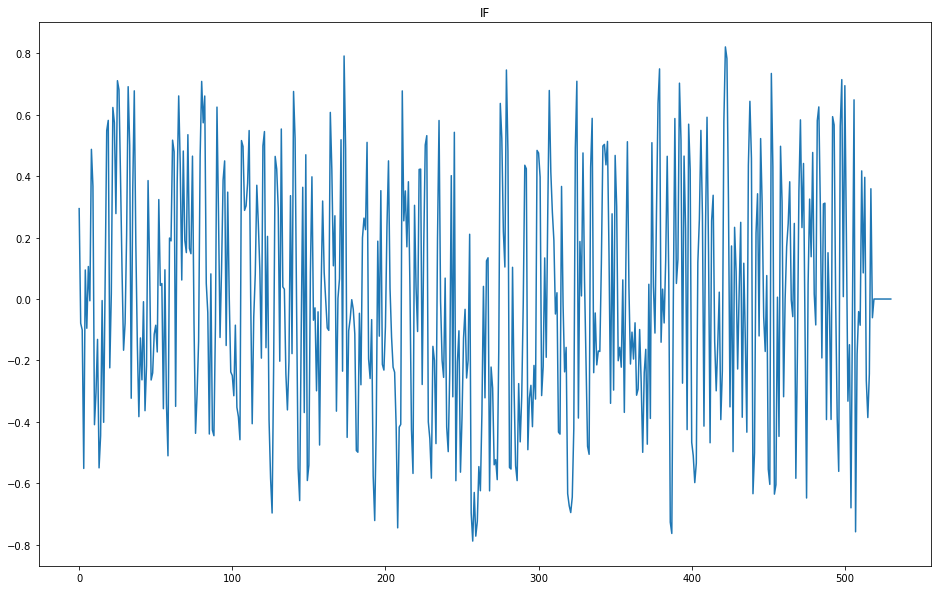

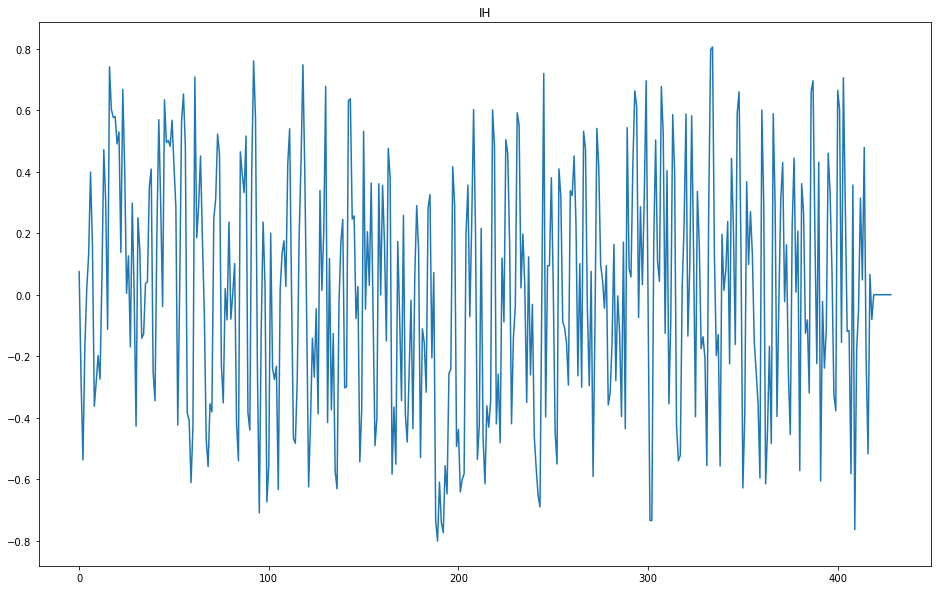

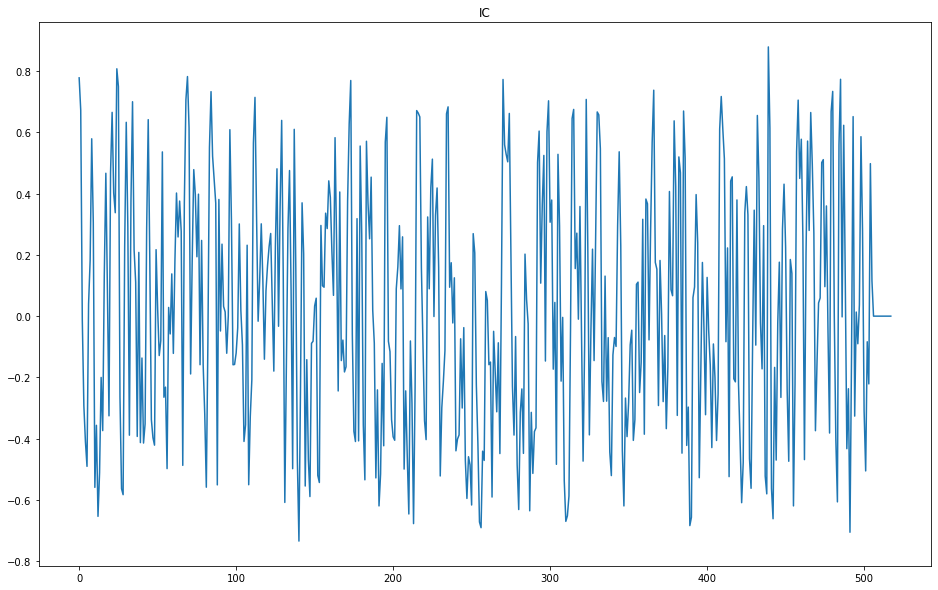

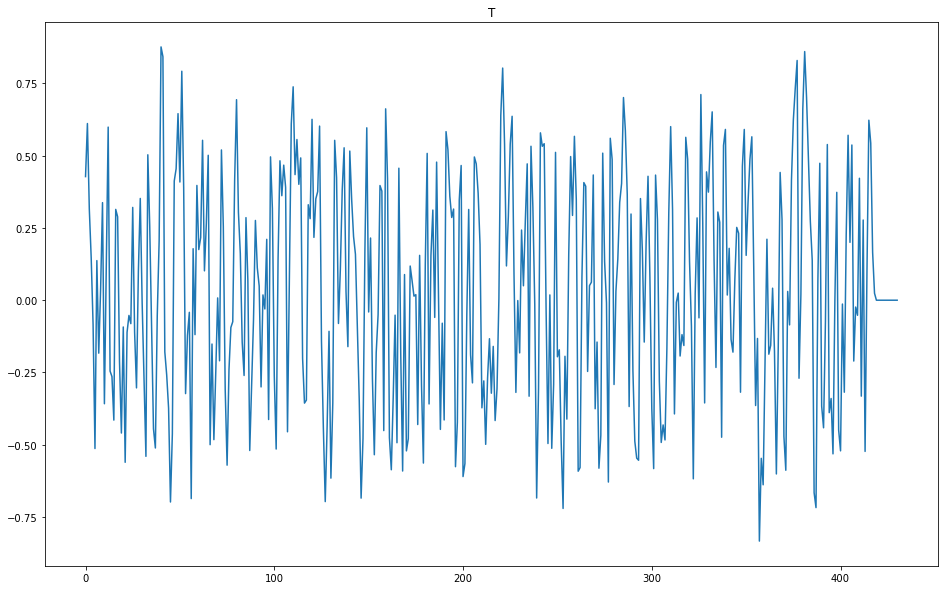

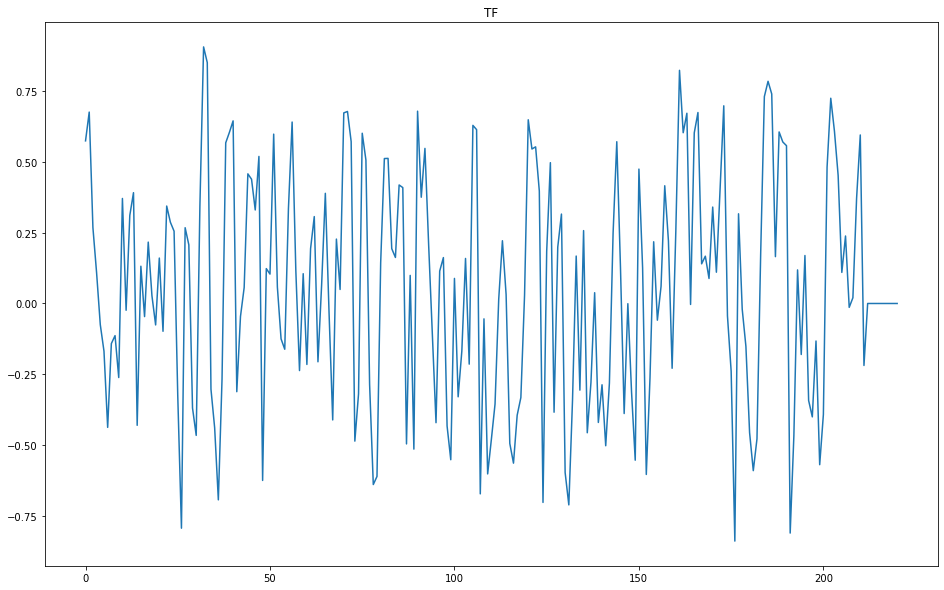

In [269]:
%%time
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.j."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1;
    plt.figure(i, figsize=(16, 10));
    plt.title(product);
    plt.plot(all_signal);
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal));
    
# IF kurtosis= 2.0819333061101686  skew= 0.0711953109490482
# IH kurtosis= 2.074640540518488  skew= -0.019368643165484117
# IC kurtosis= 2.0017536745867046  skew= 0.09770228643973687
# T kurtosis= 1.99602196631566  skew= -0.030057135321136057
# TF kurtosis= 2.1343005871520884  skew= -0.07568917540113669
# Wall time: 1min 12s



In [270]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.6, 0.8, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [271]:
%%time
signal_stat = get_list_signal_stat("kdj.j.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str = "2018", min_pnl=2, min_num=20,reverse=1)

# training
# IF
# IH
# IC
# T
# TF
# testing
# IF
# IH
# IC
# T
# TF
# Wall time: 29min 47s

training
IF
IH
IC
T
TF
testing
IF
IH
IC
T
TF
Wall time: 29min 47s


IF train sharpe  1.2887194334959673 test sharpe  0.9127481968472914
IH train sharpe  0.48690037612892584 test sharpe  -1.417322685781825
IC train sharpe  1.6181506743244198 test sharpe  0.8403213274482624
T train sharpe  0.7305364071645669 test sharpe  0.1199419711135258
TF train sharpe  1.330709749487898 test sharpe  0.6589924958317069
train sharpe:  1.842413387954823 test sharpe:  0.20313811119660904
Wall time: 367 ms


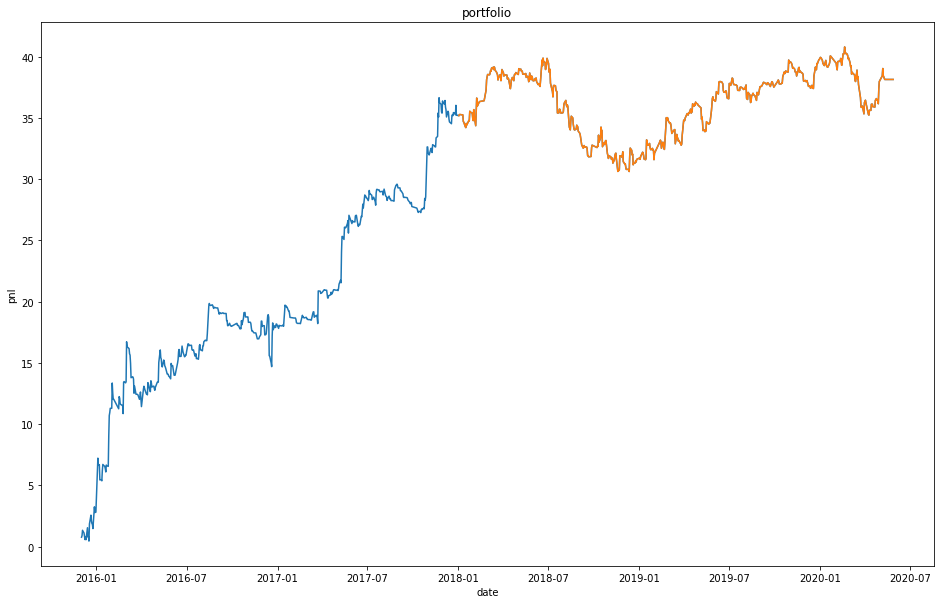

In [273]:
%%time
signal_stat = get_list_signal_result("kdj.j.4096", product_list, all_dates, reverse=1, min_pnl=2, min_num=20)

# IF train sharpe  1.2887194334959673 test sharpe  0.9127481968472914
# IH train sharpe  0.48690037612892584 test sharpe  -1.417322685781825
# IC train sharpe  1.6181506743244198 test sharpe  0.8403213274482624
# T train sharpe  0.7305364071645669 test sharpe  0.1199419711135258
# TF train sharpe  1.330709749487898 test sharpe  0.6589924958317069
# train sharpe:  1.842413387954823 test sharpe:  0.20313811119660904
# Wall time: 367 ms
